# Chess Challenge

Welcome to the chess challenge of the MQST Qiskit Fall Fest!

The queens puzzle is the problem of placing the maximum number of chess queens on an $N \times N$ chessboard such that no two queens threaten each other. It is often used as an example in various computational techniques. This problem does not have a unique solution, and the complexity of finding one increases exponentially with the size of $N$.

#### First install the necessary packages:

In [372]:
# Uncomment to install the necessary packages

%pip install --upgrade pip
%pip install numpy==2.3.4
%pip install scipy==1.16.2
%pip install matplotlib==3.10.7
%pip install jupyter
%pip install qiskit[visualization]==2.2
# # For Local Linux or Mac, you can use the following command:
# # %pip install 'qiskit[visualization]'
%pip install qiskit_algorithms==0.4.0
%pip install qiskit_aer==0.17.2
%pip install qiskit_ibm_runtime==0.41.1
%pip install qiskit_ibm_transpiler==0.14.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 1- Starting from the basics: before queens there were rooks

To start slowly, we will solve the problem for rooks, for which is much easier to find a solution but has the disadvantage that there are many more solutions. What is the max number of rooks that can fit in a 4x4 chess board? And on a 5x5?

## The first task is to create a classical function that by brute force gives the solutions for the rooks puzzle for NxN chess board.

> Tip: Represent the chess board by an NxN array filled with 0 for the empty squares and by 1 for the squares in which a rook is placed. This representation will also help you during great part of this challenge

In [168]:
import numpy as np
from itertools import permutations

def classical_rooks(N):
    """Returns the solutions of the rooks puzzle for NxN chess board.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        solutions (np.ndarray): The solutions of the rooks puzzle.
    """
    indices = list(range(N))
    all_perms = list(permutations(indices))
    solution_list = []

    for perm in all_perms:
        board = np.zeros((N, N), dtype=int)
        
        # 'perm' tells us the column for each rook.
        # 'i' will be the row index (from 0 to N-1)
        # 'j' will be the column index (the value from the permutation)
        for i, j in enumerate(perm):
            board[i, j] = 1
        solution_list.append(board)
    solutions = np.array(solution_list)
    
    return solutions

In [169]:
N = 3
solutions = classical_rooks(N)

print(f"Found {len(solutions)} solutions for a {N}x{N} board:\n")
for sol in solutions:
    print(sol)
    print("---")

Found 6 solutions for a 3x3 board:

[[1 0 0]
 [0 1 0]
 [0 0 1]]
---
[[1 0 0]
 [0 0 1]
 [0 1 0]]
---
[[0 1 0]
 [1 0 0]
 [0 0 1]]
---
[[0 1 0]
 [0 0 1]
 [1 0 0]]
---
[[0 0 1]
 [1 0 0]
 [0 1 0]]
---
[[0 0 1]
 [0 1 0]
 [1 0 0]]
---


Computing the available solutions by brute force is expensive and untractable when dealing with bigger boards, so we will take advantaje of the hybrid algorithm QAOA to solve this problem in a different way, phrasing the problem as a physics optimization problem, namely finding the state with lowest energy for a given hamiltonian.

The general form of a optimization problem can be written on the form of a hamiltonian:

$$H_C = \sum_{i,j} Q_{ij} X_i X_j + \sum_i b_i X_i$$

where $X_i$ are classical variables can be 1 or 0 and the coefficients $b_i$ and $Q_{ij}$ are problem dependent.

To find a solution using qubits, first we need to map the qubits from a quantum circuit to represent our problem. For that, one suggestion is to use the following mapping:
- Each qubit will represent one square of the chess board, so it will be identified by row and column indices.
- If there is a piece on that square, the spin will be on state $|1>$, and if it is empty the state will be $|0>$

<p style="text-align: center"><img src="https://i.imgur.com/ojkY5to.jpeg"></p>


> Example 3x3 board:
- q0 in state 0 -> 0,0
- q1 in state 0 -> 0,1
- q2 in state 0 -> 0,2
- q3 in state 0 -> 1,0
- q4 in state 0 -> 1,1
- q5 in state 1 -> 1,2
- q6 in state 0 -> 2,0
- q7 in state 0 -> 2,1
- q8 in state 0 -> 2,2

This is just a suitable mapping but it is not unique. There are many more mappings that can be used for this problem, so if you have any other please explain it and use it!!!

For the previous mapping we need $N^2$ qubits to find a solution for a NxN chess board, so a way to improve this mapping could be to reduce the number of qubits needed to map the problem. A new mapping will also change some of the following instructions... be carefull with that!!

To adapt the expression to our problem, we will change the single index $i$ of the classical variables to the actual chess board indices, where latin letters will be rows and greek indices will be columns. Therefore, the classical hamiltonian for our mapping is of the form:

$$H_C = \sum_{k,\alpha ,l,\beta} Q_{k \alpha,l \beta} X_{k\alpha}X_{l\beta} + \sum_{k\alpha} b_{k\alpha} X_{k\alpha}$$

Moreover, we need to define a specific hamiltonian whose groundstate is a solution of the rooks puzzle. For that, we will need two terms:
- One term that lowers the energy with the number of rooks ($|1>$ states)
> Tip: this is a one-body term
- One term that increases the energy if one rook threatens other. This penalization should be bigger than the energy gained by adding one other rook
> Tip: this is a two body interaction term

 Define the weigths $b_{k\alpha}$ and $Q_{k\alpha, l\beta}$ such that the previous cost function has as ground state the solution of the rook's puzzle. Make the cost of threatening 1.5 times the benefit of adding one extra rook (one extra $X$ with 1 value)

> Tip: Adding one more rook DECREASES energy, therefore $b<0$, and having threatened rooks should INCREASE it, therefore $Q>0$. Use $b=-1$ and $Q=1.5$ for those cases where the value is non-zero.

> Tip2: The rooks in chess only move vertical and horizontal, so the only relevant $Q$ coefficients are those for which $k=l$ or $\alpha=\beta$.

In [195]:
import numpy as np

b = -3
Q = 3

def classical_hamiltonian_rook_onebody_coeff(N: int, b: int) -> np.ndarray:
    # Profit for placing a rook is -b (we want to maximize the number of rooks)
    b_matrix = np.full((N, N), b)

    return b_matrix


def classical_hamiltonian_rooks_twobody_coeff(N: int, Q: int) -> np.ndarray:
    Q_matrix = np.zeros((N, N, N, N))
    
    # Penalty of a rook threatening another is +Q
    # Note the matrix is symmetric (Q_ij + Q_ji)
    symmetric_penalty = Q / 2.0

    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    is_row_threat = (k == l) and (alpha != beta)
                    is_col_threat = (alpha == beta) and (k != l)
                    
                    if is_row_threat or is_col_threat:
                        Q_matrix[k, alpha, l, beta] = symmetric_penalty
    return Q_matrix

def classical_hamiltonian_rooks(N: int, b: int, Q: int, X_matrix: np.ndarray) -> float:
    b_matrix = classical_hamiltonian_rook_onebody_coeff(N, b)
    Q_matrix = classical_hamiltonian_rooks_twobody_coeff(N, Q)
    
    # "one-body" term E_1 = sum_{k,alpha} b_{k,alpha} * X_{k,alpha}
    energy_one_body = np.sum(b_matrix * X_matrix)
    
    # 3. "two-body" term E_2 = sum_{k,alpha,l,beta} Q_{k,alpha,l,beta} * X_{k,alpha} * X_{l,beta}
    energy_two_body = 0.0
    
    for k in range(N):
        for alpha in range(N):
            # sum only if there is a rook at (k, alpha)
            if X_matrix[k, alpha] == 1:
                for l in range(N):
                    for beta in range(N):
                        # sum only if tehre is also a rook at (l, beta)
                        if X_matrix[l, beta] == 1:
                            energy_two_body += Q_matrix[k, alpha, l, beta]
    
    # total energy 
    energy = energy_one_body + energy_two_body

    return energy


In [196]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

In [197]:
# Example with N=3 (3x3 board) with solution
# X = [[1, 0, 0],
#      [0, 1, 0],
#      [1, 0, 1]]
N_3 = 3
solution_3x3 = np.array([[1, 0, 0], [0, 1, 0], [1, 0, 1]])
energy_sol_3 = classical_hamiltonian_rooks(N_3, b, Q, solution_3x3)
print(f"Energía para solución 3x3 correcta:\n{solution_3x3}\nEnergía: {energy_sol_3}")
# We expect:
# E_1 (profit) = 4 rooks * -1.0 = -4.0
# E_2 (penalty) = 0.0 (no threats)
# Total = -4.0 + 1.5 + 1.5 = -1.0

Energía para solución 3x3 correcta:
[[1 0 0]
 [0 1 0]
 [1 0 1]]
Energía: -6.0


As our system is a quantum system where the hamiltonian is an operator, whe should write it in terms of known operators. For that, we will do the change of variable
$$X_{k\alpha} = \frac{1-\hat\sigma^z_{k\alpha}}{2}$$
where $\hat \sigma^z_{k\alpha}$ is the Pauli Z operator acting on the qubit that represents the square of row $k$ and column $\alpha$. Introducing this change of variable on the previous function, you will obtain a quantum operator of the same form with an extra constant term that can be neglected because it only changes the origin of the energy.

> Hint: For this step you might need some pen and paper calculations to find the transformation!

## Write the new hamiltonian and create the associated functions to find the new coefficients

__Write here your hamiltonian__

In [201]:
def quantum_hamiltonian_rook_Z_coeff(N: int, b: int, Q: int) -> np.ndarray:
    """
    c_{k,alpha} = -b_{k,alpha}/2 - (1/2) * sum_{l,beta} Q_{k,alpha,l,beta}
    """
    b_matrix = classical_hamiltonian_rook_onebody_coeff(N, b)
    Q_matrix = classical_hamiltonian_rooks_twobody_coeff(N, Q)
    
    c_Z_matrix = np.zeros((N, N))
    
    for k in range(N):
        for alpha in range(N):
            # term -b_{k,alpha} / 2
            b_term = -b_matrix[k, alpha] / 2.0
            
            # term - (1/2) * sum_{l,beta} Q_{k,alpha,l,beta}
            Q_sum = np.sum(Q_matrix[k, alpha, :, :])
            Q_term = -0.5 * Q_sum
            
            c_Z_matrix[k, alpha] = b_term + Q_term
            
    return c_Z_matrix

def quantum_hamiltonian_rook_ZZ_coeff(N: int, Q: int) -> np.ndarray:
    """
    c_{k,alpha,l,beta} = Q_{k,alpha,l,beta} / 4
    """
    Q_matrix = classical_hamiltonian_rooks_twobody_coeff(N, Q)
    
    c_ZZ_matrix = Q_matrix / 4.0
    
    return c_ZZ_matrix

Now, we are able construct the hamiltonian for our problem, using the previous coefficients to create a quantum operator.

## Write a function that creates the hamiltonian of the rooks puzzle as a SparsePauliOp
> Tip: Use the previous functions to obtain the coefficients of the hamiltonian

In [205]:
def build_rook_hamiltonian(N: int, b: int, Q: int) -> SparsePauliOp:
    num_qubits = N * N
    
    c_Z_matrix = quantum_hamiltonian_rook_Z_coeff(N, b, Q)
    c_ZZ_matrix = quantum_hamiltonian_rook_ZZ_coeff(N, Q)
    
    pauli_list = []
    coeff_list = []
    
    # one-body term: H_Z = sum_{k,alpha} c_{k,alpha} * Z_{k,alpha}
    for k in range(N):
        for alpha in range(N):
            coeff = c_Z_matrix[k, alpha]
            if coeff != 0:
                # transform coord (k, alpha) to qubit index (which is an array)
                qubit_index = k * N + alpha
                
                # Qiskit order little-endian.
                string_index = num_qubits - 1 - qubit_index
                
                # Create string 'II...Z...II'
                z_op = ['I'] * num_qubits
                z_op[string_index] = 'Z'
                pauli_list.append("".join(z_op))
                coeff_list.append(coeff)

    # two body terms: H_ZZ = sum_{k,alpha,l,beta} c_{k,alpha,l,beta} * Z_{k,alpha} * Z_{l,beta}
    
    for k in range(N):
        for alpha in range(N):
            qubit_index_1 = k * N + alpha
            
            for l in range(N):
                for beta in range(N):
                    qubit_index_2 = l * N + beta
                    
                    if qubit_index_1 < qubit_index_2:

                        coeff_ij = c_ZZ_matrix[k, alpha, l, beta]
                        coeff_ji = c_ZZ_matrix[l, beta, k, alpha]
                        
                        # Total coeff for Z_i Z_j term is (c_ij + c_ji)
                        total_coeff = coeff_ij + coeff_ji
                        
                        if total_coeff != 0:
                            string_index_1 = num_qubits - 1 - qubit_index_1
                            string_index_2 = num_qubits - 1 - qubit_index_2
                            
                            zz_op = ['I'] * num_qubits
                            zz_op[string_index_1] = 'Z'
                            zz_op[string_index_2] = 'Z'
                            pauli_list.append("".join(zz_op))
                            coeff_list.append(total_coeff)

    hamiltonian = SparsePauliOp(pauli_list, coeffs=coeff_list)
    
    return hamiltonian

In [206]:
# Test
N_board = 2
H_quantum = build_rook_hamiltonian(N_board, b, Q)

print(f"Quantum hamiltonian for N={N_board} (num_qubits={H_quantum.num_qubits}):\n")
print(H_quantum.to_list())

Quantum hamiltonian for N=2 (num_qubits=4):

[('IIZZ', (0.75+0j)), ('IZIZ', (0.75+0j)), ('ZIZI', (0.75+0j)), ('ZZII', (0.75+0j))]


# 1.1 Finding solutions for the rook puzzle

Now that we have constructed the hamiltonian that encodes the solution of the problem, we just need to find the groundstate of it.
For that we will use the QAOA algorithm, where the circuit is optimized to find a groundstate of the cost function.

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal parameters.
Check [QAOAAnsatz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.QAOAAnsatz), and using scipy [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function run the QAOA algorithm to find the solution of the rooks puzzle, using only two layers.

> Note: There is an [example at IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) but it contains the way to run the algorithm on real hardware which up to now it is not the goal. **Check it to get inspiration but run this optimization locally using AerSimulator** or any other simulated backend.

> Note 2: The solution might not be unique


In [207]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.visualization import plot_histogram

In [291]:
# COST FUNCTION (Energy Expectation)
def cost_function_rooks_estimator(circuit, hamiltonian):
    """
    Computes the expected value <ψ|H|ψ> for a given circuit and Hamiltonian.
    """
    estimator = Estimator(mode=AerSimulator())
    job = estimator.run([(circuit, hamiltonian)])
    result = job.result()
    cost = result[0].data.evs  # expected value of H
    return float(cost)

# QAOA Optimization Routine
def QAOA_rooks(N, b, Q, cost_hamiltonian_rooks, cost_function_rooks_estimator, reps=2):
    """
    Runs QAOA with 'reps' layers for the NxN Rooks puzzle.
    """
    H = cost_hamiltonian_rooks(N, b, Q)
    num_qubits = N * N

    # QAOA ansatz (automatically includes Hadamards + alternating layers)
    ansatz = QAOAAnsatz(cost_operator=H, reps=reps)

    backend = AerSimulator()

    # define classical objective function
    energy_log = []

    def objective(params):
        bound_circuit = ansatz.assign_parameters(params)
        transpiled = transpile(bound_circuit, backend)
        energy = cost_function_rooks_estimator(transpiled, H)
        energy_log.append(energy)
        print(f"Iteración {len(energy_log)} → Energía = {energy:.6f}")
        return energy

    # random initial parameters
    initial_params = np.random.uniform(0, 2 * np.pi, len(ansatz.parameters))

    # classical optimization (COBYLA)
    result = minimize(
        objective,
        initial_params,
        method="COBYLA",
        options={"maxiter": 150, "disp": False},
    )

    # storing results
    optimal_params = result.x
    optimal_energy = result.fun

    final_circuit = ansatz.assign_parameters(optimal_params)

    # ploting energy evolution
    plt.figure(figsize=(6, 4))
    plt.plot(energy_log, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Expected Energy ⟨H⟩")
    plt.title(f"Evolution of the Energy (N={N}, reps={reps}, b={b}, Q={Q})")
    plt.grid(True)
    plt.show()

    return {
        "optimal_value": optimal_energy,
        "optimal_params": optimal_params,
        "ansatz": final_circuit,
        "energy_log": energy_log,
        "H": H,
    }

Iteración 1 → Energía = 0.849609
Iteración 2 → Energía = 13.221680
Iteración 3 → Energía = -1.973877
Iteración 4 → Energía = 0.511230
Iteración 5 → Energía = -1.475098
Iteración 6 → Energía = -0.101074
Iteración 7 → Energía = -0.190430
Iteración 8 → Energía = -2.615479
Iteración 9 → Energía = -1.908691
Iteración 10 → Energía = -2.520996
Iteración 11 → Energía = -3.374268
Iteración 12 → Energía = -3.822510
Iteración 13 → Energía = -4.701416
Iteración 14 → Energía = -4.543945
Iteración 15 → Energía = -4.620117
Iteración 16 → Energía = -3.053467
Iteración 17 → Energía = -5.204590
Iteración 18 → Energía = -5.321045
Iteración 19 → Energía = -5.249268
Iteración 20 → Energía = -5.263916
Iteración 21 → Energía = -5.299072
Iteración 22 → Energía = -5.306396
Iteración 23 → Energía = -5.381104
Iteración 24 → Energía = -5.379639
Iteración 25 → Energía = -5.317383
Iteración 26 → Energía = -5.363525
Iteración 27 → Energía = -5.336426
Iteración 28 → Energía = -5.358398
Iteración 29 → Energía = -5.282

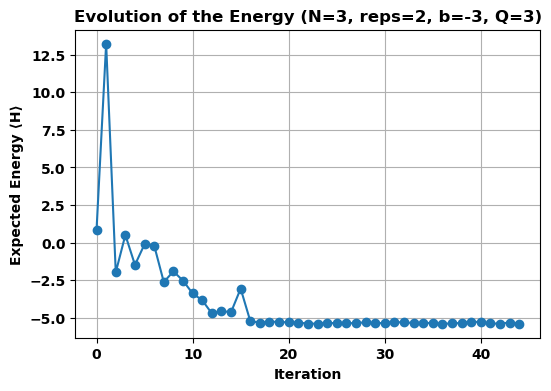

Iteración 1 → Energía = 10.097168
Iteración 2 → Energía = -0.737549
Iteración 3 → Energía = 0.177979
Iteración 4 → Energía = 4.806152
Iteración 5 → Energía = -0.135498
Iteración 6 → Energía = 5.137207
Iteración 7 → Energía = -0.089355
Iteración 8 → Energía = -0.892090
Iteración 9 → Energía = -0.025635
Iteración 10 → Energía = -0.904541
Iteración 11 → Energía = -0.789551
Iteración 12 → Energía = -0.957275
Iteración 13 → Energía = -1.111816
Iteración 14 → Energía = -0.428467
Iteración 15 → Energía = -1.128662
Iteración 16 → Energía = -1.040771
Iteración 17 → Energía = -0.958740
Iteración 18 → Energía = -1.130127
Iteración 19 → Energía = -0.985840
Iteración 20 → Energía = -1.146973
Iteración 21 → Energía = -1.000488
Iteración 22 → Energía = -1.056152
Iteración 23 → Energía = -1.014404
Iteración 24 → Energía = -1.188721
Iteración 25 → Energía = -1.199707
Iteración 26 → Energía = -1.033447
Iteración 27 → Energía = -1.070801
Iteración 28 → Energía = -1.039307
Iteración 29 → Energía = -1.1081

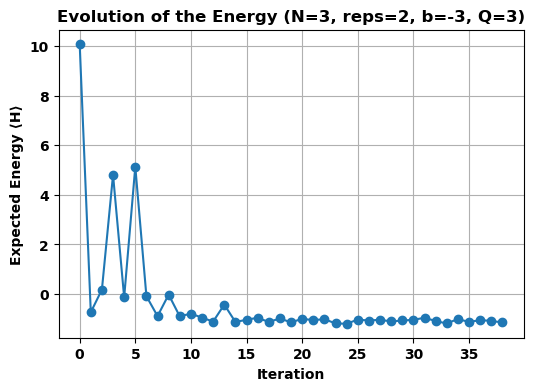

Iteración 1 → Energía = -2.735596
Iteración 2 → Energía = -0.342773
Iteración 3 → Energía = 5.617676
Iteración 4 → Energía = -0.010254
Iteración 5 → Energía = 0.008057
Iteración 6 → Energía = -3.611572
Iteración 7 → Energía = 10.553467
Iteración 8 → Energía = 7.570312
Iteración 9 → Energía = -2.760498
Iteración 10 → Energía = -5.804443
Iteración 11 → Energía = -3.552979
Iteración 12 → Energía = -5.766357
Iteración 13 → Energía = -5.210449
Iteración 14 → Energía = -5.550293
Iteración 15 → Energía = -5.848389
Iteración 16 → Energía = -5.656494
Iteración 17 → Energía = -5.074951
Iteración 18 → Energía = -5.882080
Iteración 19 → Energía = -5.997070
Iteración 20 → Energía = -5.872559
Iteración 21 → Energía = -6.005127
Iteración 22 → Energía = -6.014648
Iteración 23 → Energía = -5.998535
Iteración 24 → Energía = -6.021240
Iteración 25 → Energía = -5.938477
Iteración 26 → Energía = -6.012451
Iteración 27 → Energía = -5.975830
Iteración 28 → Energía = -5.958252
Iteración 29 → Energía = -5.9948

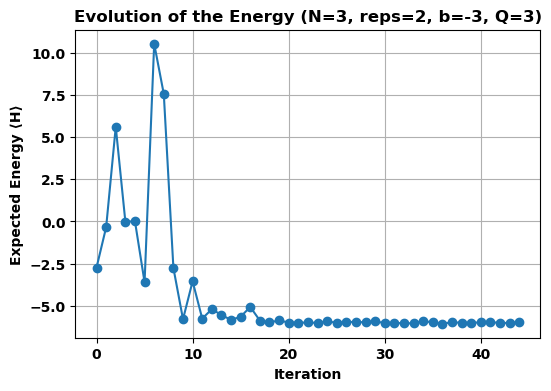

Iteración 1 → Energía = -3.498047
Iteración 2 → Energía = 4.708740
Iteración 3 → Energía = 0.483398
Iteración 4 → Energía = -0.017578
Iteración 5 → Energía = -2.553223
Iteración 6 → Energía = 2.173828
Iteración 7 → Energía = 0.904541
Iteración 8 → Energía = -3.019775
Iteración 9 → Energía = -0.468750
Iteración 10 → Energía = -3.831299
Iteración 11 → Energía = -5.081543
Iteración 12 → Energía = -5.287354
Iteración 13 → Energía = -4.360107
Iteración 14 → Energía = -5.359131
Iteración 15 → Energía = -4.803223
Iteración 16 → Energía = -5.383301
Iteración 17 → Energía = -5.453613
Iteración 18 → Energía = -5.435303
Iteración 19 → Energía = -5.484375
Iteración 20 → Energía = -5.423584
Iteración 21 → Energía = -5.495361
Iteración 22 → Energía = -5.447021
Iteración 23 → Energía = -5.465332
Iteración 24 → Energía = -5.391357
Iteración 25 → Energía = -5.533447
Iteración 26 → Energía = -5.381104
Iteración 27 → Energía = -5.518066
Iteración 28 → Energía = -5.378906
Iteración 29 → Energía = -5.45727

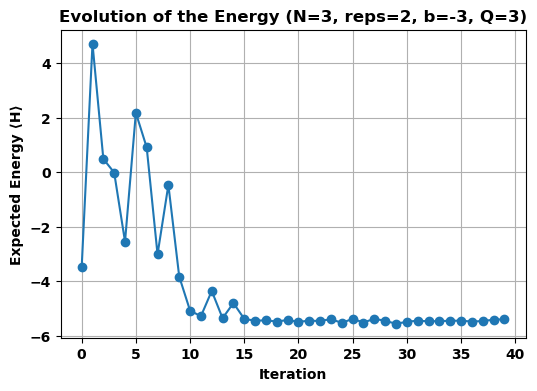

Iteración 1 → Energía = -1.818604
Iteración 2 → Energía = -1.817139
Iteración 3 → Energía = -0.949951
Iteración 4 → Energía = 0.145752
Iteración 5 → Energía = 0.247559
Iteración 6 → Energía = -0.919189
Iteración 7 → Energía = 2.926025
Iteración 8 → Energía = -1.855957
Iteración 9 → Energía = -0.799072
Iteración 10 → Energía = -2.412598
Iteración 11 → Energía = -3.257080
Iteración 12 → Energía = -4.373291
Iteración 13 → Energía = 0.781494
Iteración 14 → Energía = -4.502197
Iteración 15 → Energía = -3.482666
Iteración 16 → Energía = -4.607666
Iteración 17 → Energía = -4.328613
Iteración 18 → Energía = -3.129639
Iteración 19 → Energía = -4.480957
Iteración 20 → Energía = -4.595947
Iteración 21 → Energía = -4.647217
Iteración 22 → Energía = -4.554932
Iteración 23 → Energía = -4.581299
Iteración 24 → Energía = -4.591553
Iteración 25 → Energía = -4.617188
Iteración 26 → Energía = -4.508789
Iteración 27 → Energía = -4.634766
Iteración 28 → Energía = -4.553467
Iteración 29 → Energía = -4.62451

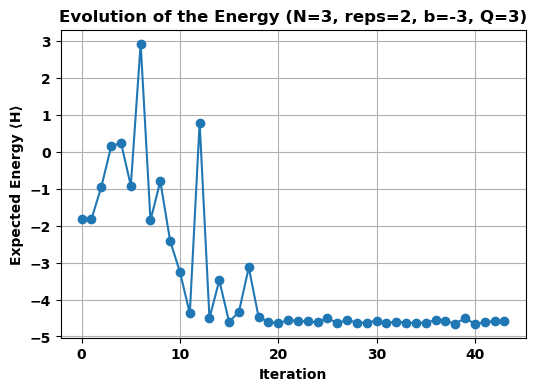

Iteración 1 → Energía = -0.513428
Iteración 2 → Energía = -2.091797
Iteración 3 → Energía = 7.943115
Iteración 4 → Energía = 1.822998
Iteración 5 → Energía = -0.086426
Iteración 6 → Energía = 0.594727
Iteración 7 → Energía = -0.021240
Iteración 8 → Energía = 0.114258
Iteración 9 → Energía = -2.870361
Iteración 10 → Energía = -3.743408
Iteración 11 → Energía = -2.994873
Iteración 12 → Energía = -4.363770
Iteración 13 → Energía = -5.327637
Iteración 14 → Energía = -3.125244
Iteración 15 → Energía = -5.427979
Iteración 16 → Energía = -5.364258
Iteración 17 → Energía = -5.399414
Iteración 18 → Energía = -5.261719
Iteración 19 → Energía = -5.354736
Iteración 20 → Energía = -5.343750
Iteración 21 → Energía = -5.396484
Iteración 22 → Energía = -5.345947
Iteración 23 → Energía = -5.374512
Iteración 24 → Energía = -5.400146
Iteración 25 → Energía = -5.354736
Iteración 26 → Energía = -5.379639
Iteración 27 → Energía = -5.346680
Iteración 28 → Energía = -5.369385
Iteración 29 → Energía = -5.36572

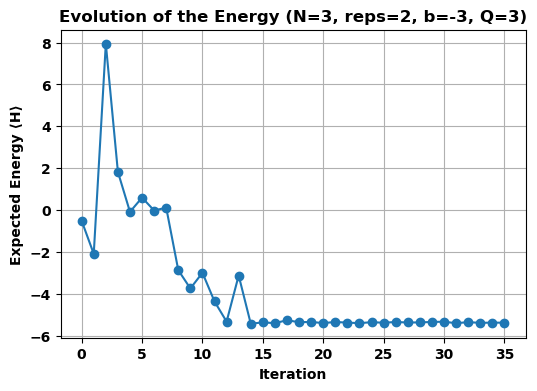

Iteración 1 → Energía = -0.298096
Iteración 2 → Energía = 1.672119
Iteración 3 → Energía = -0.041016
Iteración 4 → Energía = -0.771240
Iteración 5 → Energía = 1.021729
Iteración 6 → Energía = -1.599609
Iteración 7 → Energía = 6.424805
Iteración 8 → Energía = -2.492432
Iteración 9 → Energía = 0.569092
Iteración 10 → Energía = -4.064209
Iteración 11 → Energía = -5.222900
Iteración 12 → Energía = -2.958984
Iteración 13 → Energía = -4.057617
Iteración 14 → Energía = -5.147461
Iteración 15 → Energía = -5.362061
Iteración 16 → Energía = -6.194824
Iteración 17 → Energía = -6.641602
Iteración 18 → Energía = -5.907715
Iteración 19 → Energía = -5.943604
Iteración 20 → Energía = -6.697998
Iteración 21 → Energía = -6.104004
Iteración 22 → Energía = -6.151611
Iteración 23 → Energía = -6.710449
Iteración 24 → Energía = -6.772705
Iteración 25 → Energía = -6.789551
Iteración 26 → Energía = -6.822510
Iteración 27 → Energía = -6.773438
Iteración 28 → Energía = -6.861328
Iteración 29 → Energía = -6.72949

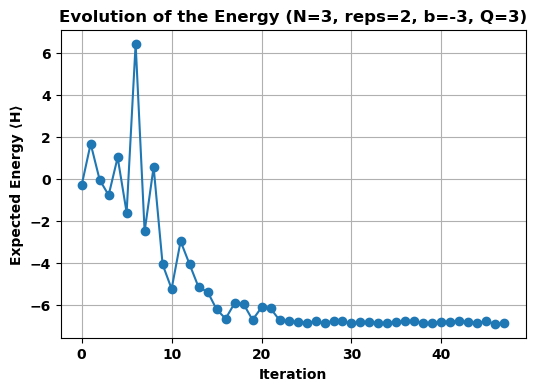

Iteración 1 → Energía = -0.113525
Iteración 2 → Energía = -2.263184
Iteración 3 → Energía = 1.543213
Iteración 4 → Energía = 3.809326
Iteración 5 → Energía = 2.900391
Iteración 6 → Energía = -0.002197
Iteración 7 → Energía = -0.509766
Iteración 8 → Energía = -1.466309
Iteración 9 → Energía = -2.644775
Iteración 10 → Energía = -1.196045
Iteración 11 → Energía = -3.282715
Iteración 12 → Energía = -4.462646
Iteración 13 → Energía = -4.940918
Iteración 14 → Energía = -4.584961
Iteración 15 → Energía = -4.639160
Iteración 16 → Energía = -5.149658
Iteración 17 → Energía = -5.201660
Iteración 18 → Energía = -4.316895
Iteración 19 → Energía = -4.968750
Iteración 20 → Energía = -4.705078
Iteración 21 → Energía = -5.345215
Iteración 22 → Energía = -5.170166
Iteración 23 → Energía = -5.306396
Iteración 24 → Energía = -5.261719
Iteración 25 → Energía = -5.281494
Iteración 26 → Energía = -5.430176
Iteración 27 → Energía = -5.364258
Iteración 28 → Energía = -5.356934
Iteración 29 → Energía = -5.3232

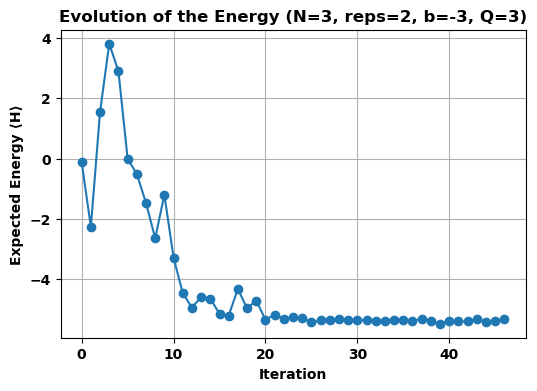

Iteración 1 → Energía = -2.630859
Iteración 2 → Energía = 5.975098
Iteración 3 → Energía = 1.832520
Iteración 4 → Energía = 1.429688
Iteración 5 → Energía = -1.921875
Iteración 6 → Energía = -0.033691
Iteración 7 → Energía = -3.707520
Iteración 8 → Energía = 0.366943
Iteración 9 → Energía = -2.765625
Iteración 10 → Energía = -2.986816
Iteración 11 → Energía = -3.933838
Iteración 12 → Energía = -3.475342
Iteración 13 → Energía = -3.176514
Iteración 14 → Energía = -5.241943
Iteración 15 → Energía = -5.813965
Iteración 16 → Energía = -5.423584
Iteración 17 → Energía = -5.299805
Iteración 18 → Energía = -6.386719
Iteración 19 → Energía = -6.019775
Iteración 20 → Energía = -6.136963
Iteración 21 → Energía = -6.427734
Iteración 22 → Energía = -6.426270
Iteración 23 → Energía = -6.446045
Iteración 24 → Energía = -6.292236
Iteración 25 → Energía = -6.430664
Iteración 26 → Energía = -6.305420
Iteración 27 → Energía = -6.347900
Iteración 28 → Energía = -6.337646
Iteración 29 → Energía = -6.33325

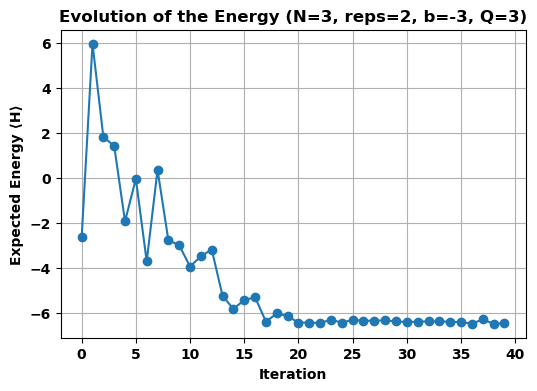

Iteración 1 → Energía = -0.131104
Iteración 2 → Energía = -0.295898
Iteración 3 → Energía = 0.616699
Iteración 4 → Energía = -2.406006
Iteración 5 → Energía = -2.214111
Iteración 6 → Energía = 3.801270
Iteración 7 → Energía = -0.838623
Iteración 8 → Energía = -2.268311
Iteración 9 → Energía = 1.727783
Iteración 10 → Energía = -2.477051
Iteración 11 → Energía = -4.185059
Iteración 12 → Energía = -4.486084
Iteración 13 → Energía = -3.576416
Iteración 14 → Energía = -4.866211
Iteración 15 → Energía = -5.427246
Iteración 16 → Energía = -5.712891
Iteración 17 → Energía = -5.761230
Iteración 18 → Energía = -5.292480
Iteración 19 → Energía = -6.061523
Iteración 20 → Energía = -4.797363
Iteración 21 → Energía = -6.177246
Iteración 22 → Energía = -6.298096
Iteración 23 → Energía = -6.337646
Iteración 24 → Energía = -6.182373
Iteración 25 → Energía = -6.325928
Iteración 26 → Energía = -6.210205
Iteración 27 → Energía = -6.290771
Iteración 28 → Energía = -6.244629
Iteración 29 → Energía = -6.2878

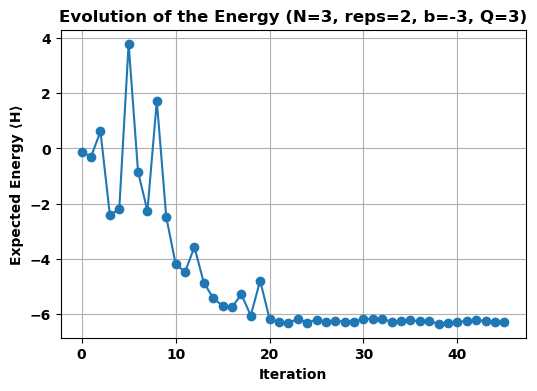


Optimal energy (QAOA): -6.879638671875
Optimal params: [1.12383979 4.95100366 4.42062101 4.78697118]


In [292]:
# RUN THE ALGORITHM
N = 3         # size of the board (3x3)
reps = 2      # number of layers of the QAOA
b = -3         # bias parameter
Q = 3         # coupling parameter

# Loop to get the best result over several runs
best_result = None
best_energy = np.inf
num_runs = 10

for run in range(num_runs):
    solutions_r = QAOA_rooks(N, b, Q, build_rook_hamiltonian, cost_function_rooks_estimator, reps=reps)

    energy_r = solutions_r["optimal_value"]

    if energy_r < best_energy:
        best_energy = energy_r
        best_result = solutions_r


solutions_r = best_result

print("\nOptimal energy (QAOA):", solutions_r["optimal_value"])
print("Optimal params:", solutions_r["optimal_params"])


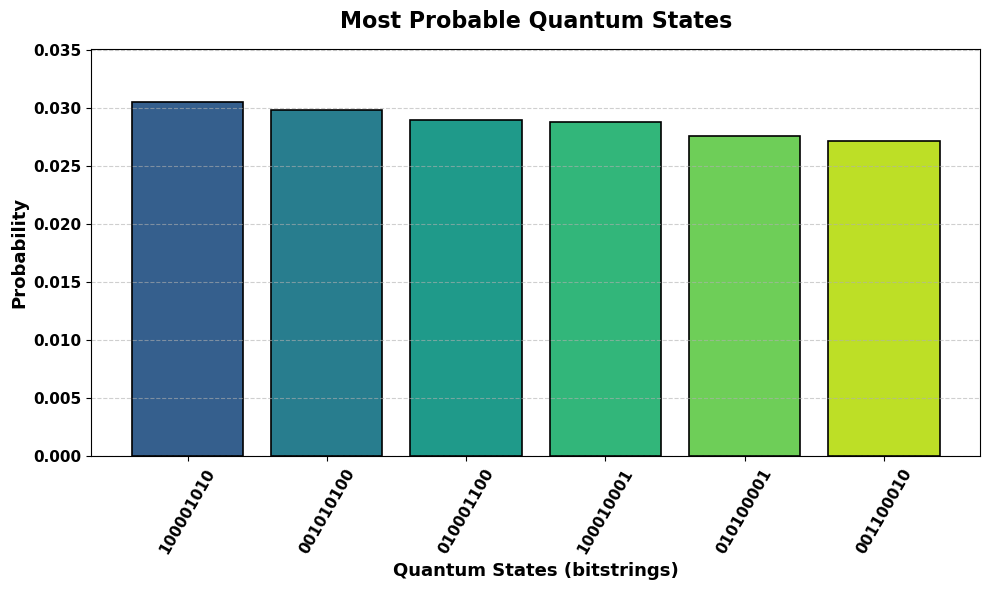

In [319]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit_aer import AerSimulator

# MEASUREMENT AND RESULTS
backend = AerSimulator()
final_circuit = solutions["ansatz"]

# Add measurements
meas_circuit = final_circuit.copy()
meas_circuit.measure_all()

# Run simulation
shots = 4096 * 8
job = backend.run(transpile(meas_circuit, backend), shots=shots)
result = job.result()
counts = result.get_counts()

# Sort and select top results
top_k = 6   # number of configurations to visualize
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
top_states = sorted_counts[:top_k]

# Convert counts to probabilities
states, counts_ = zip(*top_states)
probs = np.array(counts_) / shots

# sort for descending order
sorted_idx = np.argsort(probs)[::-1]
states = np.array(states)[sorted_idx]
probs = probs[sorted_idx]

# color gradient
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(states)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(states, probs, color=colors, edgecolor='black', linewidth=1.2)


ax.set_title("Most Probable Quantum States", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Quantum States (bitstrings)", fontsize=13)
ax.set_ylabel("Probability", fontsize=13)
ax.tick_params(axis='x', rotation=60, labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.set_ylim(0, max(probs) * 1.15)

ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# Visualization with the energy of the quantum state

def vector_to_matrix_N2(X_vector: np.ndarray, N: int) -> np.ndarray:
    """Convierte un vector de longitud N^2 en una matriz NxN.
    
    Args:
        X_vector (np.ndarray): Vector plano (1D) de longitud N^2.
        N (int): Dimensión de la matriz (tablero).

    Returns:
        np.ndarray: Matriz NxN correspondiente.
    """
    if X_vector.size != N**2:
        raise ValueError(f"El tamaño del vector ({X_vector.size}) no coincide con N^2 ({N**2}).")
    return X_vector.reshape((N, N))

def plot_histogram_energy_rooks(counts: dict, N: int, top_k: int = 30):
    """
    Plotea un histograma de los estados más probables, coloreando cada bin según su energía.

    Args:
        counts (dict): Diccionario de estados -> conteos, por ejemplo {'010100': 150, ...}
        N (int): Dimensión del tablero (para reconstruir el vector X de cada estado)
        top_k (int): Número de estados más probables a mostrar
    """
    # Ordenar los estados por probabilidad descendente
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    top_counts = sorted_counts[:top_k]

    states = []
    probs = []
    energies = []

    for state_str, count in top_counts:
        states.append(state_str)
        probs.append(count / sum(counts.values()))
        # Convertir el string binario a vector plano de 0/1
        X_vector = np.array([int(bit) for bit in state_str])
        # Convertir el vector en matriz NxN
        X_matrix = vector_to_matrix_N2(X_vector, N)
        # Evaluar energía
        E = classical_hamiltonian_rooks(N, b, Q, X_matrix)
        energies.append(E)

    energies = np.array(energies)
    norm = plt.Normalize(energies.min(), energies.max())
    colors = plt.cm.viridis(norm(energies))

    # Crear figura y eje
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(states, probs, color=colors)
    ax.set_xticks(range(len(states)))
    ax.set_xticklabels(states, rotation=45)
    ax.set_xlabel("Quantum states", fontsize=12)
    ax.tick_params(axis='x')
    ax.set_ylabel("Relative frequency", fontsize=12)
    ax.set_title(f"Top {top_k} most probable states", fontsize=12)

    # Crear colorbar asociada al eje y con los datos de energía
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array(energies)  # ahora tiene datos reales
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Energy of the quantum state ⟨H⟩", fontsize=10)

    plt.tight_layout()
    plt.show()

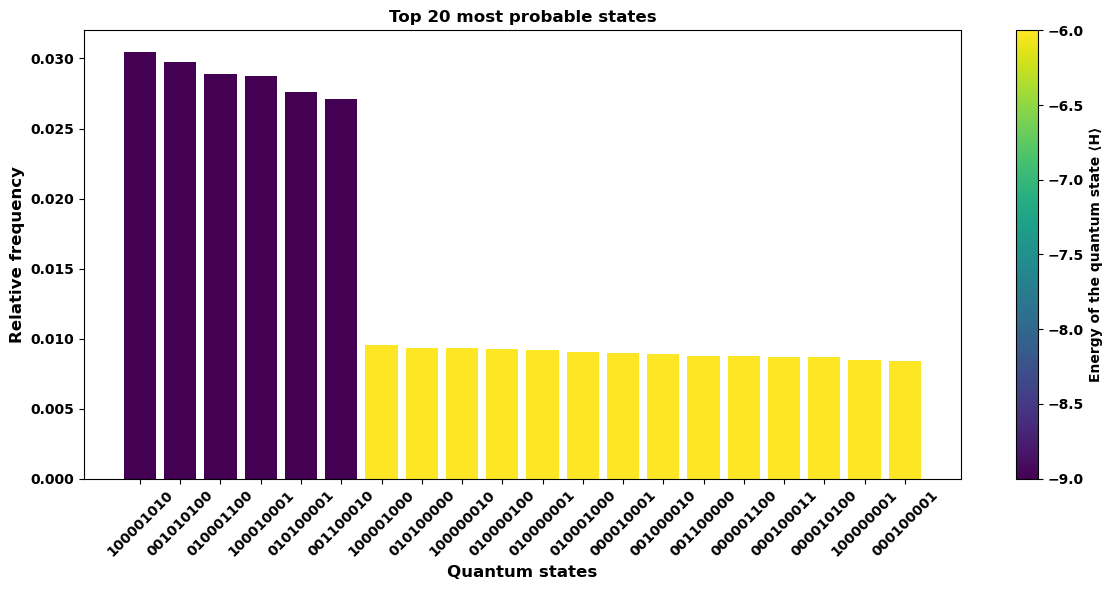

In [328]:
plot_histogram_energy(counts, N, top_k=20)

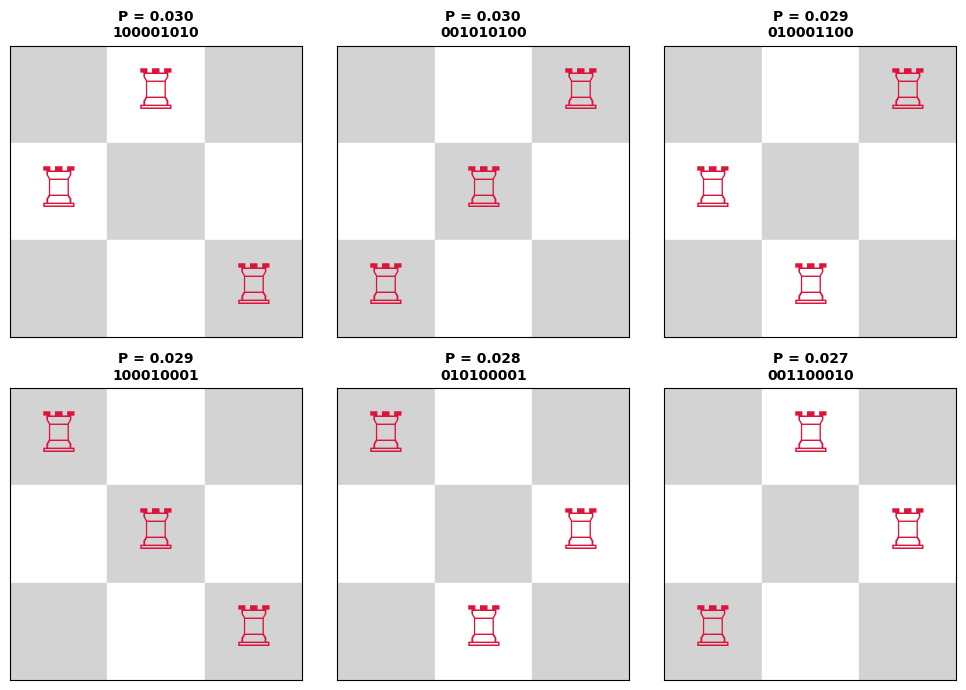

In [321]:
# VISUALIZATION OF TOP CONFIGURATIONS (courtesy of chat gpt)

def plot_rooks_configuration(bitstring, N, ax):
    """Draws an NxN chessboard with rooks (♖) where bits=1."""
    board = np.zeros((N, N))
    bits = bitstring[::-1]
    for i, bit in enumerate(bits):
        if bit == "1":
            r, c = divmod(i, N)
            board[r, c] = 1

    # Draw squares
    for r in range(N):
        for c in range(N):
            color = "lightgray" if (r + c) % 2 == 0 else "white"
            ax.add_patch(plt.Rectangle((c - 0.5, N - 1 - r - 0.5), 1, 1, color=color))

    # Draw rooks
    for r in range(N):
        for c in range(N):
            if board[r, c] == 1:
                ax.text(c, N - 1 - r, "♖", ha="center", va="center", fontsize=40, color="crimson")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, N - 0.5)
    ax.set_aspect("equal")


# Display grid of top configurations
rows = int(np.ceil(top_k / 3))
cols = min(3, top_k)
fig, axes = plt.subplots(rows, cols, figsize=(10, 3.5 * rows))
# fig.suptitle(f"Top {top_k} most probable configurations (N={N}, b={b}, Q={Q})", fontsize=14)

axes = np.array(axes).reshape(-1)
for i, (bitstring, count) in enumerate(top_states):
    prob = count / shots
    plot_rooks_configuration(bitstring, N, axes[i])
    axes[i].set_title(f"P = {prob:.3f}\n{bitstring}", fontsize=10)

for j in range(len(top_states), len(axes)):
    axes[j].axis("off")

fig.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.show()


In [371]:
# brute force rooks
import itertools
import numpy as np

def rooks_conflict(pos1, pos2):
    (r1, c1), (r2, c2) = pos1, pos2
    return (r1 == r2) or (c1 == c2)

def valid_rook_config(positions):
    for (p1, p2) in itertools.combinations(positions, 2):
        if rooks_conflict(p1, p2):
            return False
    return True

def brute_force_max_rooks(N):
    cells = [(i, j) for i in range(N) for j in range(N)]
    best_solutions = []
    max_rooks = 0

    for num_rooks in range(1, N * N + 1):
        current_solutions = []
        for combo in itertools.combinations(cells, num_rooks):
            if valid_rook_config(combo):
                current_solutions.append(combo)

        if current_solutions:
            max_rooks = num_rooks
            best_solutions = current_solutions
            print(f"{len(current_solutions)} valid configurations with {num_rooks} rooks")
        else:
            print("No more valid configurations found.")
            break

    print(f"\nMaximum number of rooks: {max_rooks}")
    print(f"Number of valid configurations: {len(best_solutions)}")

    return max_rooks, best_solutions

def print_board(N, positions):
    board = np.zeros((N, N), dtype=int)
    for (r, c) in positions:
        board[r, c] = 1
    print(board, "\n")


N = 3
max_rooks, best_solutions = brute_force_max_rooks(N)

print(f"\nMaximum number of rooks for {N}x{N}: {max_rooks}")
print(f"Showing all {len(best_solutions)} valid configurations:\n")

for idx, sol in enumerate(best_solutions, 1):
    print(f"Configuration {idx}:")
    print_board(N, sol)


9 valid configurations with 1 rooks
18 valid configurations with 2 rooks
6 valid configurations with 3 rooks
No more valid configurations found.

Maximum number of rooks: 3
Number of valid configurations: 6

Maximum number of rooks for 3x3: 3
Showing all 6 valid configurations:

Configuration 1:
[[1 0 0]
 [0 1 0]
 [0 0 1]] 

Configuration 2:
[[1 0 0]
 [0 0 1]
 [0 1 0]] 

Configuration 3:
[[0 1 0]
 [1 0 0]
 [0 0 1]] 

Configuration 4:
[[0 1 0]
 [0 0 1]
 [1 0 0]] 

Configuration 5:
[[0 0 1]
 [1 0 0]
 [0 1 0]] 

Configuration 6:
[[0 0 1]
 [0 1 0]
 [1 0 0]] 



## Run the QAOA algorithm for 3x3 and 4x4 boards and discuss the solutions obtained.
## Compare the solutions with the ones obtained by brute force.

# 1.2 Finding a specific solution for the rook puzzle

As you might have seen before, the solution obtained using the previous hamiltonian is usually a superposition of all possible configurations of rooks on the board. To obtain a single solution, we must break the degeneracy of the solution by unbalancing the positions in which the rooks appear.

One of the simplest ways to do this is "tilting" the chess board, i.e., favoring the positioning of the rooks on one side of the board. To do this, one can add a small bias on the single-body terms of the form:

- $b_{00}$ <- $b_{00}$
- $b_{01}$ <- $b_{01}$ + $\delta$
- $b_{02}$ <- $b_{02}$ + $\sqrt{2}\delta$
- ...
- $b_{NN}$ <- $b_{NN}$ + $N\delta$

where $\delta$ should be small compared with the value of $b$ and $Q$, but not infinitely small. You might optimize this by comparing some solutions for different values of $\delta$, or maybe use your creativity to break the degeneracy using different weights and method.

## Introduce the modification on the one-body terms and run again all the steps of the algorithm to find a solution of the rook puzzle. What is the accuracy for the algorithm to find the solution?

> Extra: Can you implement this bias also for the brute force search?

In [ ]:
def classical_hamiltonian_rook_onebody_coeff_tilted(N):
    """Returns the NxN matrix of b_{k \alpha} weigths for a tilted chess board.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        b_vector (np.array): The NxN matrix of b_{k \alpha} weigths.
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
    """
    # Your code here

    return b_vector


# The rest of your code here

# 1.3 Improving the optimization

Now that everything is working properly, let's improve the QAOA protocol. Test the convergence of the solution and the parameters by changing different parameters of the algorithm.

Can you find a classical optimization algorithm that converges faster than the one by default on scipy.optimize? Does it change the result on the QAOA algorithm?

Does the convergence or the final solution improve using a different mixing operator?

How does the convergence and final solution change if we increase the number of layers from 2 to 3? How does the computation time change?

In [ ]:
# Test different possibilities here

# 2- Diagonal movement

As the queens can also move in diagonal, we will carefully analyze that movement playing the same game with bishops. (Be careful, this time for a board of NxN squares there are more than N possible bishops!!!!!!!!!!)

Repeat all previous steps with the bishops puzzle, to understand how can the diagonal movement be introduced in the hamiltonian. Fill all the following steps and comment everything you do to find the solution for 3x3 and 4x4 boards:

In [369]:
# Create the brute force function to find the solutions of the bishop puzzle
import itertools
import numpy as np

def bishops_conflict(pos1, pos2):
    (r1, c1), (r2, c2) = pos1, pos2
    return abs(r1 - r2) == abs(c1 - c2)

def valid_bishop_config(positions):
    for (p1, p2) in itertools.combinations(positions, 2):
        if bishops_conflict(p1, p2):
            return False
    return True

def brute_force_max_bishops(N):
    cells = [(i, j) for i in range(N) for j in range(N)]
    best_solutions = []
    max_bishops = 0

    for num_bishops in range(1, N * N + 1):
        current_solutions = []
        for combo in itertools.combinations(cells, num_bishops):
            if valid_bishop_config(combo):
                current_solutions.append(combo)

        if current_solutions:
            max_bishops = num_bishops
            best_solutions = current_solutions
            print(f"{len(current_solutions)} valid configurations with {num_bishops} bishops")
        else:
            print("No more valid configurations found.")
            break

    print(f"\nMaximum number of bishops: {max_bishops}")
    print(f"Number of valid configurations: {len(best_solutions)}")

    return max_bishops, best_solutions

def print_board(N, positions):
    board = np.zeros((N, N), dtype=int)
    for (r, c) in positions:
        board[r, c] = 1
    print(board, "\n")


N = 4
max_bishops, best_solutions = brute_force_max_bishops(N)

print(f"\nMaximum number of bishops for {N}x{N}: {max_bishops}")
print(f"Showing all {len(best_solutions)} valid configurations:\n")

for idx, sol in enumerate(best_solutions, 1):
    print(f"Configuration {idx}:")
    print_board(N, sol)


16 valid configurations with 1 bishops
92 valid configurations with 2 bishops
232 valid configurations with 3 bishops
260 valid configurations with 4 bishops
112 valid configurations with 5 bishops
16 valid configurations with 6 bishops
No more valid configurations found.

Maximum number of bishops: 6
Number of valid configurations: 16

Maximum number of bishops for 4x4: 6
Showing all 16 valid configurations:

Configuration 1:
[[1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 1 0]] 

Configuration 2:
[[1 1 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]] 

Configuration 3:
[[1 1 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]] 

Configuration 4:
[[1 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 1 0]] 

Configuration 5:
[[1 0 1 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]] 

Configuration 6:
[[1 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 1 0 0]] 

Configuration 7:
[[1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [0 0 0 0]] 

Configuration 8:
[[1 0 0 0]
 [1 0 0 1]
 [1 0 0 1]
 [1 0 0 0]] 

Configuration 9:
[[0 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 1 1]] 

Configurat

In [331]:
# CLASSICAL HAMILTONIAN

def classical_hamiltonian_bishop_onebody_coeff(N: int, b: float) -> np.ndarray:
    """One-body term (benefit for placing a bishop)."""
    return np.full((N, N), b)


def classical_hamiltonian_bishop_twobody_coeff(N: int, Q: float) -> np.ndarray:
    """Two-body term (penalty for attacking bishops on diagonals)."""
    Q_matrix = np.zeros((N, N, N, N))
    symmetric_penalty = Q / 2.0

    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    # Bishops threaten each other on diagonals
                    is_diag_threat = (abs(k - l) == abs(alpha - beta)) and (k != l)
                    if is_diag_threat:
                        Q_matrix[k, alpha, l, beta] = symmetric_penalty

    return Q_matrix


def classical_hamiltonian_bishop(N: int, b: float, Q: float, X_matrix: np.ndarray) -> float:
    """Classical Hamiltonian evaluation."""
    b_matrix = classical_hamiltonian_bishop_onebody_coeff(N, b)
    Q_matrix = classical_hamiltonian_bishop_twobody_coeff(N, Q)

    energy_one_body = np.sum(b_matrix * X_matrix)
    energy_two_body = 0.0

    for k in range(N):
        for alpha in range(N):
            if X_matrix[k, alpha] == 1:
                for l in range(N):
                    for beta in range(N):
                        if X_matrix[l, beta] == 1:
                            energy_two_body += Q_matrix[k, alpha, l, beta]

    return energy_one_body + energy_two_body


# QUANTUM HAMILTONIAN

def quantum_hamiltonian_bishop_Z_coeff(N: int, b: float, Q: float) -> np.ndarray:
    b_matrix = classical_hamiltonian_bishop_onebody_coeff(N, b)
    Q_matrix = classical_hamiltonian_bishop_twobody_coeff(N, Q)

    c_Z_matrix = np.zeros((N, N))
    for k in range(N):
        for alpha in range(N):
            b_term = -b_matrix[k, alpha] / 2.0
            Q_term = -0.5 * np.sum(Q_matrix[k, alpha, :, :])
            c_Z_matrix[k, alpha] = b_term + Q_term
    return c_Z_matrix


def quantum_hamiltonian_bishop_ZZ_coeff(N: int, Q: float) -> np.ndarray:
    return classical_hamiltonian_bishop_twobody_coeff(N, Q) / 4.0


def build_bishop_hamiltonian(N: int, b: float, Q: float) -> SparsePauliOp:
    num_qubits = N * N
    c_Z_matrix = quantum_hamiltonian_bishop_Z_coeff(N, b, Q)
    c_ZZ_matrix = quantum_hamiltonian_bishop_ZZ_coeff(N, Q)

    pauli_list, coeff_list = [], []

    # One-body terms
    for k in range(N):
        for alpha in range(N):
            coeff = c_Z_matrix[k, alpha]
            if coeff != 0:
                qubit_index = k * N + alpha
                string_index = num_qubits - 1 - qubit_index
                z_op = ['I'] * num_qubits
                z_op[string_index] = 'Z'
                pauli_list.append("".join(z_op))
                coeff_list.append(coeff)

    # Two-body terms
    for k in range(N):
        for alpha in range(N):
            qubit_index_1 = k * N + alpha
            for l in range(N):
                for beta in range(N):
                    qubit_index_2 = l * N + beta
                    if qubit_index_1 < qubit_index_2:
                        coeff = c_ZZ_matrix[k, alpha, l, beta] + c_ZZ_matrix[l, beta, k, alpha]
                        if coeff != 0:
                            z_op = ['I'] * num_qubits
                            z_op[num_qubits - 1 - qubit_index_1] = 'Z'
                            z_op[num_qubits - 1 - qubit_index_2] = 'Z'
                            pauli_list.append("".join(z_op))
                            coeff_list.append(coeff)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

# COST FUNCTION AND QAOA OPTIMIZATION

def cost_function_bishops_estimator(circuit, hamiltonian):
    estimator = Estimator(mode=AerSimulator())
    job = estimator.run([(circuit, hamiltonian)])
    return float(job.result()[0].data.evs)


def QAOA_bishops(N, b, Q, cost_hamiltonian_bishops, cost_function_bishops_estimator, reps=2):
    H = cost_hamiltonian_bishops(N, b, Q)
    num_qubits = N * N
    ansatz = QAOAAnsatz(cost_operator=H, reps=reps)
    backend = AerSimulator()
    energy_log = []

    def objective(params):
        bound_circuit = ansatz.assign_parameters(params)
        energy = cost_function_bishops_estimator(transpile(bound_circuit, backend), H)
        energy_log.append(energy)
        print(f"Iteration {len(energy_log)} → Energy = {energy:.6f}")
        return energy

    initial_params = np.random.uniform(0, 2 * np.pi, len(ansatz.parameters))
    result = minimize(objective, initial_params, method="COBYLA", options={"maxiter": 150, "disp": False})

    plt.figure(figsize=(6, 4))
    plt.plot(energy_log, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Expected Energy ⟨H⟩")
    plt.title(f"Energy Evolution (Bishops, N={N}, b={b}, Q={Q})")
    plt.grid(True)
    plt.show()

    return {"optimal_value": result.fun, "optimal_params": result.x, "ansatz": ansatz.assign_parameters(result.x), "energy_log": energy_log, "H": H}


Iteration 1 → Energy = -2.477783
Iteration 2 → Energy = 1.638428
Iteration 3 → Energy = -1.024658
Iteration 4 → Energy = 3.218262
Iteration 5 → Energy = 3.271729
Iteration 6 → Energy = 2.805176
Iteration 7 → Energy = 2.772217
Iteration 8 → Energy = -2.715820
Iteration 9 → Energy = -4.400391
Iteration 10 → Energy = -2.457275
Iteration 11 → Energy = -4.527100
Iteration 12 → Energy = -4.563721
Iteration 13 → Energy = -4.365234
Iteration 14 → Energy = -4.398193
Iteration 15 → Energy = -4.298584
Iteration 16 → Energy = -4.446533
Iteration 17 → Energy = -4.492676
Iteration 18 → Energy = -4.532227
Iteration 19 → Energy = -4.513184
Iteration 20 → Energy = -4.447998
Iteration 21 → Energy = -4.468506
Iteration 22 → Energy = -4.519775
Iteration 23 → Energy = -4.470703
Iteration 24 → Energy = -4.472900
Iteration 25 → Energy = -4.483154
Iteration 26 → Energy = -4.497070
Iteration 27 → Energy = -4.552002
Iteration 28 → Energy = -4.509521
Iteration 29 → Energy = -4.498535
Iteration 30 → Energy = -4.5

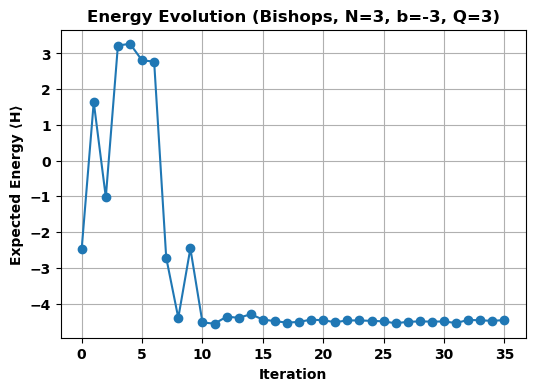

Iteration 1 → Energy = 1.642822
Iteration 2 → Energy = -1.461182
Iteration 3 → Energy = 2.922363
Iteration 4 → Energy = 2.096924
Iteration 5 → Energy = 0.884033
Iteration 6 → Energy = -0.684082
Iteration 7 → Energy = 1.454590
Iteration 8 → Energy = -0.082031
Iteration 9 → Energy = -1.614990
Iteration 10 → Energy = -2.051514
Iteration 11 → Energy = -2.173096
Iteration 12 → Energy = -2.767822
Iteration 13 → Energy = -2.781006
Iteration 14 → Energy = -2.367920
Iteration 15 → Energy = -2.965576
Iteration 16 → Energy = -2.983887
Iteration 17 → Energy = -3.122314
Iteration 18 → Energy = -3.000732
Iteration 19 → Energy = -3.154541
Iteration 20 → Energy = -2.622070
Iteration 21 → Energy = -3.126709
Iteration 22 → Energy = -3.144287
Iteration 23 → Energy = -3.104004
Iteration 24 → Energy = -3.136230
Iteration 25 → Energy = -3.224854
Iteration 26 → Energy = -3.186035
Iteration 27 → Energy = -3.142822
Iteration 28 → Energy = -3.228516
Iteration 29 → Energy = -3.180176
Iteration 30 → Energy = -3.2

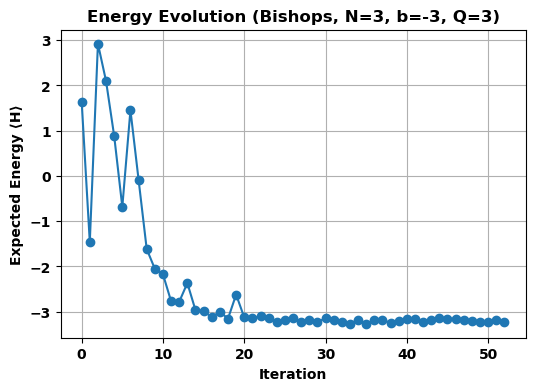

Iteration 1 → Energy = 0.277588
Iteration 2 → Energy = 1.765137
Iteration 3 → Energy = 2.072754
Iteration 4 → Energy = 1.631104
Iteration 5 → Energy = 2.137939
Iteration 6 → Energy = -1.426025
Iteration 7 → Energy = -0.957275
Iteration 8 → Energy = -1.630371
Iteration 9 → Energy = -0.869385
Iteration 10 → Energy = -1.672852
Iteration 11 → Energy = -1.452393
Iteration 12 → Energy = -1.130127
Iteration 13 → Energy = -2.367920
Iteration 14 → Energy = -2.525391
Iteration 15 → Energy = -2.321777
Iteration 16 → Energy = -2.260986
Iteration 17 → Energy = -2.485107
Iteration 18 → Energy = -2.534180
Iteration 19 → Energy = -2.468994
Iteration 20 → Energy = -2.564941
Iteration 21 → Energy = -2.425049
Iteration 22 → Energy = -2.477051
Iteration 23 → Energy = -2.493896
Iteration 24 → Energy = -2.555420
Iteration 25 → Energy = -2.566406
Iteration 26 → Energy = -2.529053
Iteration 27 → Energy = -2.545898
Iteration 28 → Energy = -2.600830
Iteration 29 → Energy = -2.397217
Iteration 30 → Energy = -2.4

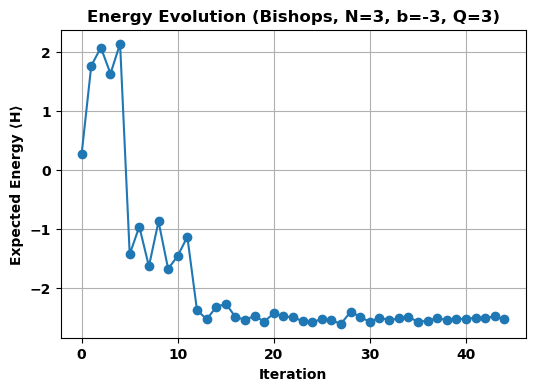

Iteration 1 → Energy = -1.324951
Iteration 2 → Energy = -0.586670
Iteration 3 → Energy = 0.203613
Iteration 4 → Energy = 1.129395
Iteration 5 → Energy = -1.492676
Iteration 6 → Energy = 3.497314
Iteration 7 → Energy = -1.636963
Iteration 8 → Energy = -0.079102
Iteration 9 → Energy = -1.333740
Iteration 10 → Energy = -1.443604
Iteration 11 → Energy = -1.526367
Iteration 12 → Energy = -1.921143
Iteration 13 → Energy = -2.044189
Iteration 14 → Energy = -1.477295
Iteration 15 → Energy = -1.677246
Iteration 16 → Energy = -1.796631
Iteration 17 → Energy = -2.843262
Iteration 18 → Energy = -2.775146
Iteration 19 → Energy = -2.887939
Iteration 20 → Energy = -2.938477
Iteration 21 → Energy = -2.873291
Iteration 22 → Energy = -2.882812
Iteration 23 → Energy = -3.043213
Iteration 24 → Energy = -3.120117
Iteration 25 → Energy = -3.125977
Iteration 26 → Energy = -3.227051
Iteration 27 → Energy = -3.301758
Iteration 28 → Energy = -3.398438
Iteration 29 → Energy = -3.479004
Iteration 30 → Energy = -3

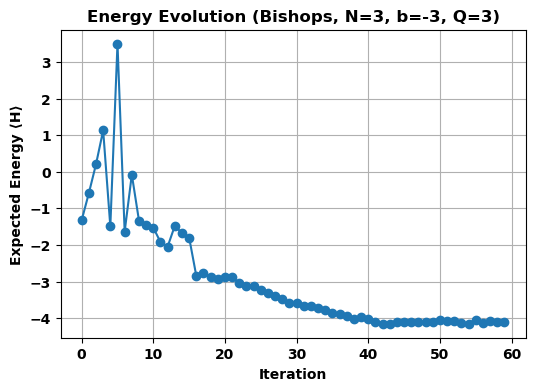

Iteration 1 → Energy = 3.734619
Iteration 2 → Energy = 0.960205
Iteration 3 → Energy = 0.281982
Iteration 4 → Energy = 1.322754
Iteration 5 → Energy = 1.234131
Iteration 6 → Energy = -0.101807
Iteration 7 → Energy = -1.984131
Iteration 8 → Energy = -0.960205
Iteration 9 → Energy = 1.894043
Iteration 10 → Energy = 2.923096
Iteration 11 → Energy = -1.954834
Iteration 12 → Energy = -0.947754
Iteration 13 → Energy = -3.470947
Iteration 14 → Energy = 0.259277
Iteration 15 → Energy = 0.848145
Iteration 16 → Energy = 2.418457
Iteration 17 → Energy = -1.012207
Iteration 18 → Energy = -3.337646
Iteration 19 → Energy = -3.672363
Iteration 20 → Energy = -3.257080
Iteration 21 → Energy = -3.922119
Iteration 22 → Energy = -3.759521
Iteration 23 → Energy = -3.579346
Iteration 24 → Energy = -4.135986
Iteration 25 → Energy = -3.931641
Iteration 26 → Energy = -4.214355
Iteration 27 → Energy = -4.179199
Iteration 28 → Energy = -4.151367
Iteration 29 → Energy = -4.335938
Iteration 30 → Energy = -4.445801

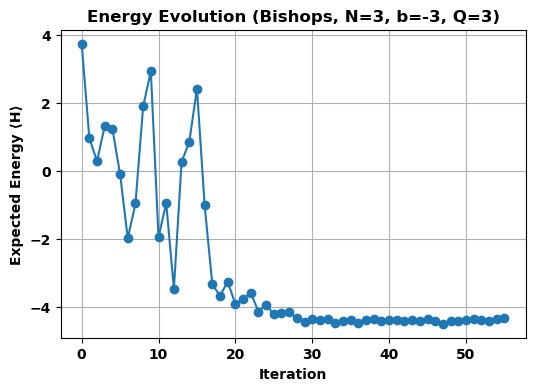

Iteration 1 → Energy = 0.928711
Iteration 2 → Energy = -1.607666
Iteration 3 → Energy = 0.405029
Iteration 4 → Energy = -2.928223
Iteration 5 → Energy = 3.728760
Iteration 6 → Energy = 0.701660
Iteration 7 → Energy = 1.557129
Iteration 8 → Energy = -3.055664
Iteration 9 → Energy = -1.801758
Iteration 10 → Energy = -2.892334
Iteration 11 → Energy = -4.004150
Iteration 12 → Energy = -4.551270
Iteration 13 → Energy = -4.733643
Iteration 14 → Energy = -4.677246
Iteration 15 → Energy = -4.582031
Iteration 16 → Energy = -4.348389
Iteration 17 → Energy = -4.684570
Iteration 18 → Energy = -4.706543
Iteration 19 → Energy = -4.737305
Iteration 20 → Energy = -4.593750
Iteration 21 → Energy = -4.779785
Iteration 22 → Energy = -4.820068
Iteration 23 → Energy = -4.761475
Iteration 24 → Energy = -4.762207
Iteration 25 → Energy = -4.769531
Iteration 26 → Energy = -4.745361
Iteration 27 → Energy = -4.768066
Iteration 28 → Energy = -4.766602
Iteration 29 → Energy = -4.779053
Iteration 30 → Energy = -4.6

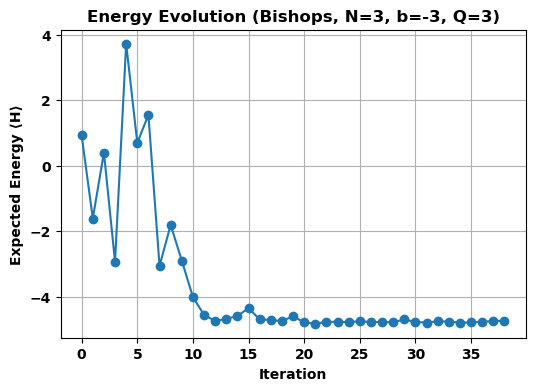

Iteration 1 → Energy = -2.676270
Iteration 2 → Energy = 3.048340
Iteration 3 → Energy = -1.133789
Iteration 4 → Energy = 4.125732
Iteration 5 → Energy = -2.111572
Iteration 6 → Energy = -0.396240
Iteration 7 → Energy = 1.482422
Iteration 8 → Energy = -1.814941
Iteration 9 → Energy = -2.625000
Iteration 10 → Energy = -2.904053
Iteration 11 → Energy = -1.929199
Iteration 12 → Energy = -2.942871
Iteration 13 → Energy = -3.324463
Iteration 14 → Energy = -3.263672
Iteration 15 → Energy = -3.260742
Iteration 16 → Energy = -3.245361
Iteration 17 → Energy = -3.427734
Iteration 18 → Energy = -3.396240
Iteration 19 → Energy = -3.292236
Iteration 20 → Energy = -3.407227
Iteration 21 → Energy = -3.429932
Iteration 22 → Energy = -3.309814
Iteration 23 → Energy = -3.385986
Iteration 24 → Energy = -3.431396
Iteration 25 → Energy = -3.301025
Iteration 26 → Energy = -3.370605
Iteration 27 → Energy = -3.418945
Iteration 28 → Energy = -3.376465
Iteration 29 → Energy = -3.394775
Iteration 30 → Energy = -3

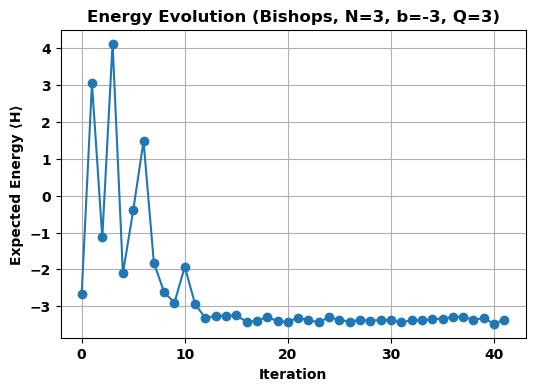

Iteration 1 → Energy = 0.536133
Iteration 2 → Energy = -2.771484
Iteration 3 → Energy = 3.725098
Iteration 4 → Energy = 2.941406
Iteration 5 → Energy = 2.911377
Iteration 6 → Energy = 2.793457
Iteration 7 → Energy = -0.358154
Iteration 8 → Energy = -1.209961
Iteration 9 → Energy = -3.142822
Iteration 10 → Energy = -2.906982
Iteration 11 → Energy = -2.883545
Iteration 12 → Energy = -3.844482
Iteration 13 → Energy = -3.991699
Iteration 14 → Energy = -3.670166
Iteration 15 → Energy = -3.921387
Iteration 16 → Energy = -3.524414
Iteration 17 → Energy = -3.949219
Iteration 18 → Energy = -3.832031
Iteration 19 → Energy = -3.970459
Iteration 20 → Energy = -4.042236
Iteration 21 → Energy = -4.130859
Iteration 22 → Energy = -3.914795
Iteration 23 → Energy = -4.005615
Iteration 24 → Energy = -4.088379
Iteration 25 → Energy = -4.097168
Iteration 26 → Energy = -4.009277
Iteration 27 → Energy = -3.986572
Iteration 28 → Energy = -4.006348
Iteration 29 → Energy = -4.051758
Iteration 30 → Energy = -4.0

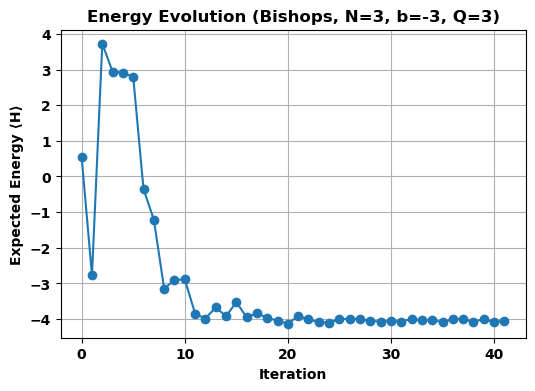

Iteration 1 → Energy = 0.461426
Iteration 2 → Energy = 0.826172
Iteration 3 → Energy = -1.426025
Iteration 4 → Energy = -0.010254
Iteration 5 → Energy = 3.095947
Iteration 6 → Energy = 1.773193
Iteration 7 → Energy = 0.452637
Iteration 8 → Energy = -1.915283
Iteration 9 → Energy = -2.567139
Iteration 10 → Energy = -1.307373
Iteration 11 → Energy = -2.343018
Iteration 12 → Energy = -2.457275
Iteration 13 → Energy = -2.467529
Iteration 14 → Energy = -2.545166
Iteration 15 → Energy = -2.269775
Iteration 16 → Energy = -2.367188
Iteration 17 → Energy = -2.576660
Iteration 18 → Energy = -2.514404
Iteration 19 → Energy = -2.512207
Iteration 20 → Energy = -2.466797
Iteration 21 → Energy = -2.482910
Iteration 22 → Energy = -2.559082
Iteration 23 → Energy = -2.520264
Iteration 24 → Energy = -2.546631
Iteration 25 → Energy = -2.502686
Iteration 26 → Energy = -2.506348
Iteration 27 → Energy = -2.584717
Iteration 28 → Energy = -2.499756
Iteration 29 → Energy = -2.526123
Iteration 30 → Energy = -2.4

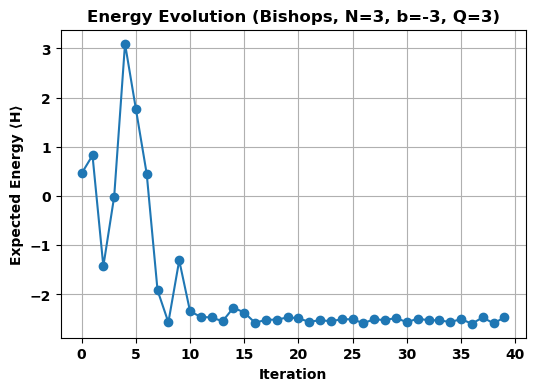

Iteration 1 → Energy = -1.220215
Iteration 2 → Energy = 1.186523
Iteration 3 → Energy = -0.637939
Iteration 4 → Energy = 2.758301
Iteration 5 → Energy = 3.292236
Iteration 6 → Energy = 1.594482
Iteration 7 → Energy = 2.261719
Iteration 8 → Energy = -1.209229
Iteration 9 → Energy = -2.932617
Iteration 10 → Energy = -2.506348
Iteration 11 → Energy = -2.898193
Iteration 12 → Energy = -2.372314
Iteration 13 → Energy = -2.761963
Iteration 14 → Energy = -3.117188
Iteration 15 → Energy = -3.032959
Iteration 16 → Energy = -2.798584
Iteration 17 → Energy = -3.383057
Iteration 18 → Energy = -3.442383
Iteration 19 → Energy = -2.872559
Iteration 20 → Energy = -3.667969
Iteration 21 → Energy = -3.719238
Iteration 22 → Energy = -4.137451
Iteration 23 → Energy = -4.299316
Iteration 24 → Energy = -4.553467
Iteration 25 → Energy = -4.626709
Iteration 26 → Energy = -4.151367
Iteration 27 → Energy = -4.608398
Iteration 28 → Energy = -4.924805
Iteration 29 → Energy = -4.623779
Iteration 30 → Energy = -4.8

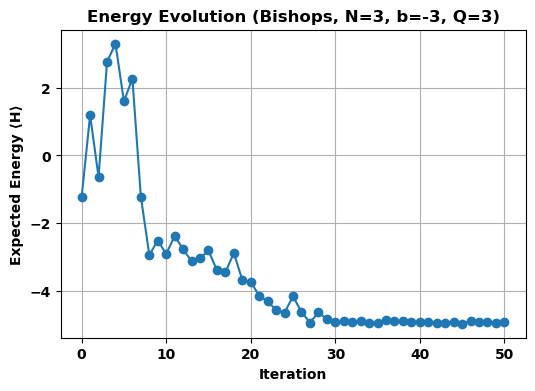


Optimal energy (QAOA): -4.956298828125
Optimal params: [2.75485399 0.72679233 1.13284388 0.49074118]


In [336]:
# RUN THE ALGORITHM
N = 3
reps = 2
b = -3
Q = 3

# Loop to get the best result over several runs
best_result = None
best_energy = np.inf
num_runs = 10

for run in range(num_runs):
    solutions_b = QAOA_bishops(
        N=N, b=b, Q=Q,
        cost_hamiltonian_bishops=build_bishop_hamiltonian,
        cost_function_bishops_estimator=cost_function_bishops_estimator,
        reps=reps
    )
    energy_b = solutions_b["optimal_value"]

    if energy_b < best_energy:
        best_energy = energy_b
        best_result = solutions_b


solutions_b = best_result

print("\nOptimal energy (QAOA):", solutions_b["optimal_value"])
print("Optimal params:", solutions_b["optimal_params"])


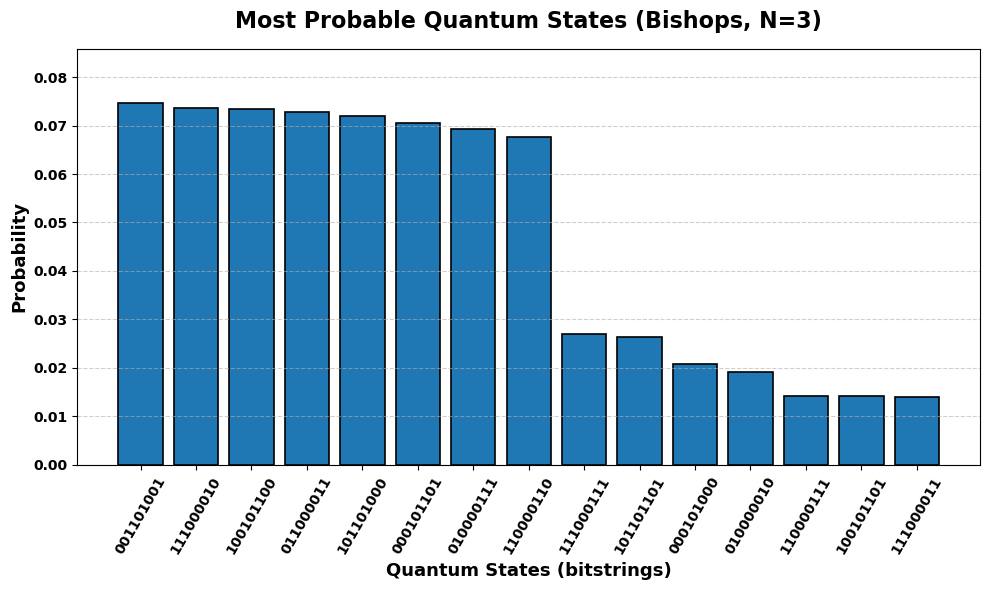

In [346]:
# MEASUREMENT AND VISUALIZATION

backend = AerSimulator()
final_circuit = solutions_b["ansatz"]

meas_circuit = final_circuit.copy()
meas_circuit.measure_all()
shots = 4096 * 8
job = backend.run(transpile(meas_circuit, backend), shots=shots)
counts = job.result().get_counts()

top_k = 15
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
states, counts_ = zip(*sorted_counts)
probs = np.array(counts_) / shots

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(states, probs, edgecolor='black', linewidth=1.2)
ax.set_title(f"Most Probable Quantum States (Bishops, N={N})", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Quantum States (bitstrings)", fontsize=13)
ax.set_ylabel("Probability", fontsize=13)
ax.tick_params(axis='x', rotation=60)
ax.set_ylim(0, max(probs)*1.15)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

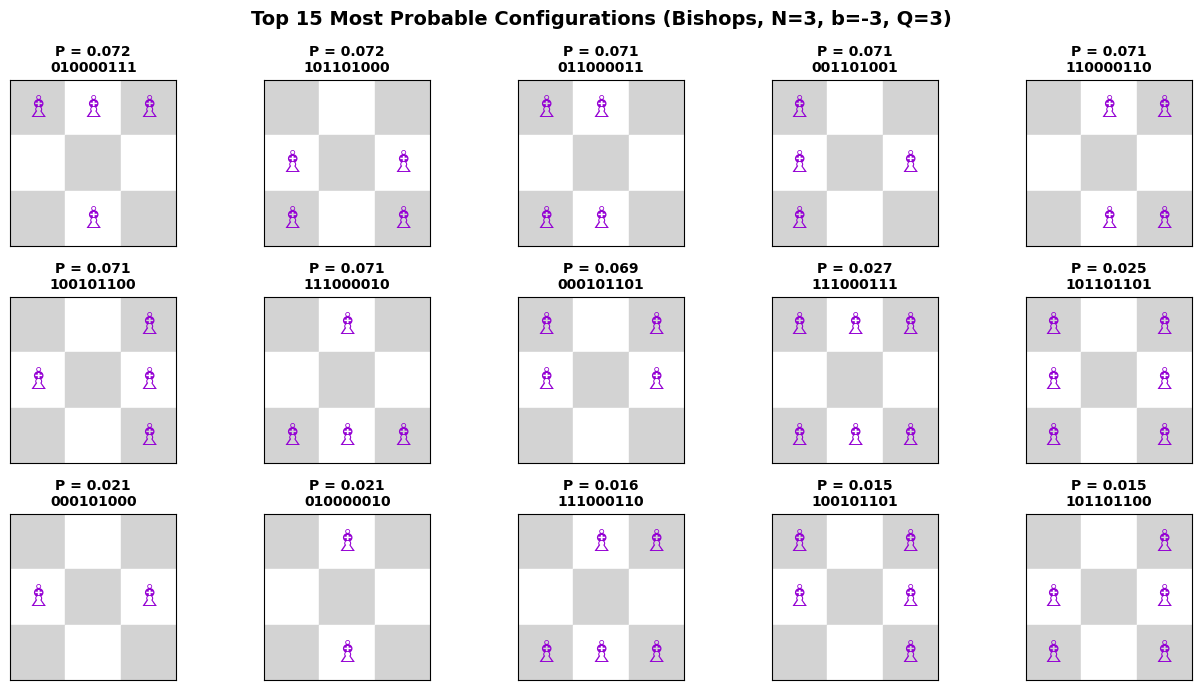

In [340]:
# VISUALIZATION OF TOP CONFIGURATIONS

def plot_bishops_configuration(bitstring, N, ax):
    board = np.zeros((N, N))
    bits = bitstring[::-1]
    for i, bit in enumerate(bits):
        if bit == "1":
            r, c = divmod(i, N)
            board[r, c] = 1

    for r in range(N):
        for c in range(N):
            color = "lightgray" if (r + c) % 2 == 0 else "white"
            ax.add_patch(plt.Rectangle((c - 0.5, N - 1 - r - 0.5), 1, 1, color=color))
            if board[r, c] == 1:
                ax.text(c, N - 1 - r, "♗", ha="center", va="center", fontsize=22, color="darkviolet")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, N - 0.5)
    ax.set_aspect("equal")


fig, axes = plt.subplots(3, 5, figsize=(13, 7))
fig.suptitle(f"Top {top_k} Most Probable Configurations (Bishops, N={N}, b={b}, Q={Q})", fontsize=14)
axes = axes.flatten()

for i, (bitstring, count) in enumerate(sorted_counts):
    prob = count / shots
    plot_bishops_configuration(bitstring, N, axes[i])
    axes[i].set_title(f"P = {prob:.3f}\n{bitstring}", fontsize=10)

for j in range(len(sorted_counts), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# 3- The queens puzzle

Now that we have analyzed both movements of the queens, we can put everything together and find a solution for the queens problem. For that, you only need to combine the two body interactions of the rooks with those of the bishops and voila! The queens cost hamiltonian is done!

Repeat again the previous steps to find the solution for the queens puzzle for 3x3 and 4x4 boards. You can jump some steps if you find them unnecessary, but at the end you should compare the brute force solutions with those obtained by QAOA

In [370]:
# Create the brute force function to find the solutions of the queens puzzle
import itertools
import numpy as np

def queens_conflict(pos1, pos2):
    (r1, c1), (r2, c2) = pos1, pos2
    return (r1 == r2) or (c1 == c2) or (abs(r1 - r2) == abs(c1 - c2))

def valid_queen_config(positions):
    for (p1, p2) in itertools.combinations(positions, 2):
        if queens_conflict(p1, p2):
            return False
    return True

def brute_force_max_queens(N):
    cells = [(i, j) for i in range(N) for j in range(N)]
    best_solutions = []
    max_queens = 0

    for num_queens in range(1, N + 1):
        current_solutions = []
        for combo in itertools.combinations(cells, num_queens):
            if valid_queen_config(combo):
                current_solutions.append(combo)

        if current_solutions:
            max_queens = num_queens
            best_solutions = current_solutions
            print(f"{len(current_solutions)} valid configurations with {num_queens} queens")
        else:
            print("No more valid configurations found.")
            break

    print(f"\nMaximum number of queens: {max_queens}")
    print(f"Number of valid configurations: {len(best_solutions)}\n")

    return max_queens, best_solutions

def print_board(N, positions):
    board = np.zeros((N, N), dtype=int)
    for (r, c) in positions:
        board[r, c] = 1
    print(board, "\n")


N = 3
max_queens, best_solutions = brute_force_max_queens(N)

print(f"\nMaximum number of queens for {N}x{N}: {max_queens}")

for idx, sol in enumerate(best_solutions, 1):
    print(f"Configuration {idx}:")
    print_board(N, sol)


9 valid configurations with 1 queens
8 valid configurations with 2 queens
No more valid configurations found.

Maximum number of queens: 2
Number of valid configurations: 8


Maximum number of queens for 3x3: 2
Configuration 1:
[[1 0 0]
 [0 0 1]
 [0 0 0]] 

Configuration 2:
[[1 0 0]
 [0 0 0]
 [0 1 0]] 

Configuration 3:
[[0 1 0]
 [0 0 0]
 [1 0 0]] 

Configuration 4:
[[0 1 0]
 [0 0 0]
 [0 0 1]] 

Configuration 5:
[[0 0 1]
 [1 0 0]
 [0 0 0]] 

Configuration 6:
[[0 0 1]
 [0 0 0]
 [0 1 0]] 

Configuration 7:
[[0 0 0]
 [1 0 0]
 [0 0 1]] 

Configuration 8:
[[0 0 0]
 [0 0 1]
 [1 0 0]] 



In [228]:
# Classical coefficients

def classical_onebody_coeff(N: int, b: float) -> np.ndarray:
    return np.full((N, N), b)

def classical_rook_twobody_coeff(N: int, Q_rook: float) -> np.ndarray:
    Q = np.zeros((N, N, N, N))
    half = Q_rook / 2.0
    for k in range(N):
        for a in range(N):
            for l in range(N):
                for b_ in range(N):
                    is_row = (k == l) and (a != b_)
                    is_col = (a == b_) and (k != l)
                    if is_row or is_col:
                        Q[k, a, l, b_] = half
    return Q

def classical_bishop_twobody_coeff(N: int, Q_bishop: float) -> np.ndarray:
    Q = np.zeros((N, N, N, N))
    half = Q_bishop / 2.0
    for k in range(N):
        for a in range(N):
            for l in range(N):
                for b_ in range(N):
                    # diagonal threats
                    if (abs(k - l) == abs(a - b_)) and (k != l):
                        Q[k, a, l, b_] = half
    return Q

def classical_queen_twobody_coeff(N: int, Q_rook: float, Q_bishop: float) -> np.ndarray:
    Q_r = classical_rook_twobody_coeff(N, Q_rook)
    Q_b = classical_bishop_twobody_coeff(N, Q_bishop)
    return Q_r + Q_b

def classical_hamiltonian_queens(N: int, b: float, Q_rook: float, Q_bishop: float, X_matrix: np.ndarray) -> float:
    b_mat = classical_onebody_coeff(N, b)
    Q_mat = classical_queen_twobody_coeff(N, Q_rook, Q_bishop)
    e1 = np.sum(b_mat * X_matrix)
    e2 = 0.0
    for k in range(N):
        for a in range(N):
            if X_matrix[k, a] == 1:
                for l in range(N):
                    for b_ in range(N):
                        if X_matrix[l, b_] == 1:
                            e2 += Q_mat[k, a, l, b_]
    return e1 + e2

# Quantum coefficients

def quantum_Z_coeff_queens(N: int, b: float, Q_rook: float, Q_bishop: float) -> np.ndarray:
    b_mat = classical_onebody_coeff(N, b)
    Q_mat = classical_queen_twobody_coeff(N, Q_rook, Q_bishop)
    cZ = np.zeros((N, N))
    for k in range(N):
        for a in range(N):
            b_term = -b_mat[k, a] / 2.0
            Q_term = -0.5 * np.sum(Q_mat[k, a, :, :])
            cZ[k, a] = b_term + Q_term
    return cZ

def quantum_ZZ_coeff_queens(N: int, Q_rook: float, Q_bishop: float) -> np.ndarray:
    Q_mat = classical_queen_twobody_coeff(N, Q_rook, Q_bishop)
    return Q_mat / 4.0


# Build SparsePauliOp Hamiltonian

def build_queen_hamiltonian(N: int, b: float, Q_rook: float, Q_bishop: float) -> SparsePauliOp:
    num_qubits = N * N
    cZ = quantum_Z_coeff_queens(N, b, Q_rook, Q_bishop)
    cZZ = quantum_ZZ_coeff_queens(N, Q_rook, Q_bishop)
    pauli_list = []
    coeff_list = []
    # Z terms
    for k in range(N):
        for a in range(N):
            coeff = cZ[k, a]
            if coeff != 0:
                qubit_index = k * N + a
                string_index = num_qubits - 1 - qubit_index
                z_op = ['I'] * num_qubits
                z_op[string_index] = 'Z'
                pauli_list.append("".join(z_op))
                coeff_list.append(coeff)
    # ZZ terms
    for k in range(N):
        for a in range(N):
            i = k * N + a
            for l in range(N):
                for b_ in range(N):
                    j = l * N + b_
                    if i < j:
                        coeff = cZZ[k, a, l, b_] + cZZ[l, b_, k, a]
                        if coeff != 0:
                            s = ['I'] * num_qubits
                            s[num_qubits - 1 - i] = 'Z'
                            s[num_qubits - 1 - j] = 'Z'
                            pauli_list.append("".join(s))
                            coeff_list.append(coeff)
    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [358]:
# QAOA routine (queens)

def cost_function_estimator(circuit, hamiltonian):
    estimator = Estimator(mode=AerSimulator())
    job = estimator.run([(circuit, hamiltonian)])
    result = job.result()
    return float(result[0].data.evs)

def QAOA_queens(N, b, Q_rook, Q_bishop, cost_hamiltonian, cost_function, reps=2):
    H = cost_hamiltonian(N, b, Q_rook, Q_bishop)
    ansatz = QAOAAnsatz(cost_operator=H, reps=reps)
    backend = AerSimulator()
    energy_log = []
    def objective(params):
        bound = ansatz.assign_parameters(params)
        transp = transpile(bound, backend)
        val = cost_function(transp, H)
        energy_log.append(val)
        print(f"Iter {len(energy_log)} -> Energy = {val:.6f}")
        return val
    init = np.random.uniform(0, 2 * np.pi, len(ansatz.parameters))
    res = minimize(objective, init, method="COBYLA", options={"maxiter": 150, "disp": False})
    final_circuit = ansatz.assign_parameters(res.x)
    plt.figure(figsize=(6,4))
    plt.plot(energy_log, marker='o')
    plt.xlabel("Iteration"); plt.ylabel("Expected Energy ⟨H⟩")
    plt.title(f"Energy Evolution (Queens, N={N}, reps={reps}, b={b}, Qr={Q_rook}, Qb={Q_bishop})")
    plt.grid(True); plt.show()
    return {"optimal_value": res.fun, "optimal_params": res.x, "ansatz": final_circuit, "energy_log": energy_log, "H": H}


Iter 1 -> Energy = 0.571533
Iter 2 -> Energy = 0.739990
Iter 3 -> Energy = 1.660400
Iter 4 -> Energy = -0.415771
Iter 5 -> Energy = 0.124268
Iter 6 -> Energy = -0.019531
Iter 7 -> Energy = -3.306641
Iter 8 -> Energy = 0.985107
Iter 9 -> Energy = 15.001465
Iter 10 -> Energy = -3.143799
Iter 11 -> Energy = -6.065186
Iter 12 -> Energy = -3.925781
Iter 13 -> Energy = -5.532227
Iter 14 -> Energy = -7.451904
Iter 15 -> Energy = -8.175537
Iter 16 -> Energy = -7.214111
Iter 17 -> Energy = -8.094727
Iter 18 -> Energy = -8.537109
Iter 19 -> Energy = -4.790039
Iter 20 -> Energy = -8.385498
Iter 21 -> Energy = -8.458008
Iter 22 -> Energy = -8.545166
Iter 23 -> Energy = -8.489258
Iter 24 -> Energy = -8.500488
Iter 25 -> Energy = -8.447510
Iter 26 -> Energy = -8.465088
Iter 27 -> Energy = -8.575928
Iter 28 -> Energy = -8.595459
Iter 29 -> Energy = -8.532227
Iter 30 -> Energy = -8.614746
Iter 31 -> Energy = -8.577637
Iter 32 -> Energy = -8.571533
Iter 33 -> Energy = -8.560059
Iter 34 -> Energy = -8.6

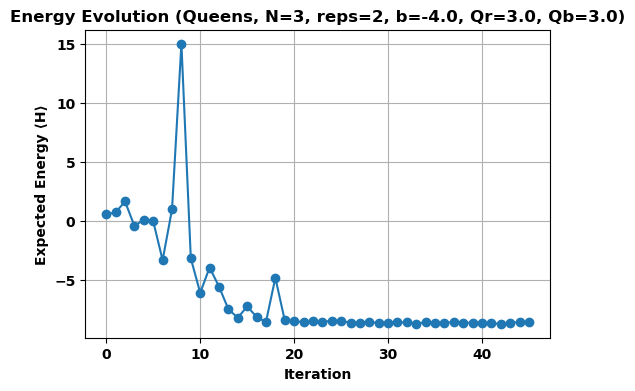

Iter 1 -> Energy = -4.771484
Iter 2 -> Energy = 0.256348
Iter 3 -> Energy = 11.319580
Iter 4 -> Energy = 0.213135
Iter 5 -> Energy = -4.541260
Iter 6 -> Energy = 1.516602
Iter 7 -> Energy = -2.040283
Iter 8 -> Energy = -4.001221
Iter 9 -> Energy = -4.784424
Iter 10 -> Energy = -5.171387
Iter 11 -> Energy = -5.970215
Iter 12 -> Energy = -6.522705
Iter 13 -> Energy = -5.532715
Iter 14 -> Energy = -4.781494
Iter 15 -> Energy = -3.439209
Iter 16 -> Energy = -5.966797
Iter 17 -> Energy = -6.940186
Iter 18 -> Energy = -4.994629
Iter 19 -> Energy = -6.746826
Iter 20 -> Energy = -5.731445
Iter 21 -> Energy = -7.520264
Iter 22 -> Energy = -6.598145
Iter 23 -> Energy = -7.489258
Iter 24 -> Energy = -7.781250
Iter 25 -> Energy = -7.632324
Iter 26 -> Energy = -7.808105
Iter 27 -> Energy = -7.796387
Iter 28 -> Energy = -7.706787
Iter 29 -> Energy = -7.831787
Iter 30 -> Energy = -7.844238
Iter 31 -> Energy = -7.864746
Iter 32 -> Energy = -7.806152
Iter 33 -> Energy = -7.757568
Iter 34 -> Energy = -7

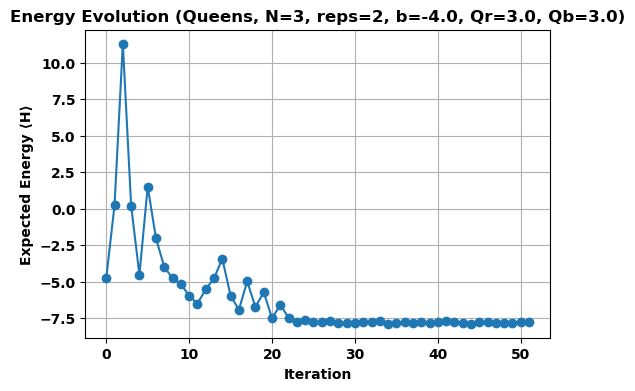

Iter 1 -> Energy = -1.060791
Iter 2 -> Energy = -1.230469
Iter 3 -> Energy = 4.764648
Iter 4 -> Energy = 3.546875
Iter 5 -> Energy = 0.777832
Iter 6 -> Energy = 0.180908
Iter 7 -> Energy = 0.051025
Iter 8 -> Energy = -0.963867
Iter 9 -> Energy = -1.406738
Iter 10 -> Energy = -3.222412
Iter 11 -> Energy = 3.441406
Iter 12 -> Energy = -2.945068
Iter 13 -> Energy = -3.235107
Iter 14 -> Energy = -1.278320
Iter 15 -> Energy = -2.236084
Iter 16 -> Energy = -2.039062
Iter 17 -> Energy = -2.998291
Iter 18 -> Energy = -3.202881
Iter 19 -> Energy = -3.010742
Iter 20 -> Energy = -3.050537
Iter 21 -> Energy = -2.755859
Iter 22 -> Energy = -3.034180
Iter 23 -> Energy = -3.036377
Iter 24 -> Energy = -3.190186
Iter 25 -> Energy = -3.317383
Iter 26 -> Energy = -3.195068
Iter 27 -> Energy = -3.063232
Iter 28 -> Energy = -3.311035
Iter 29 -> Energy = -3.171875
Iter 30 -> Energy = -3.102539
Iter 31 -> Energy = -3.053711
Iter 32 -> Energy = -3.014648
Iter 33 -> Energy = -3.027588
Iter 34 -> Energy = -3.10

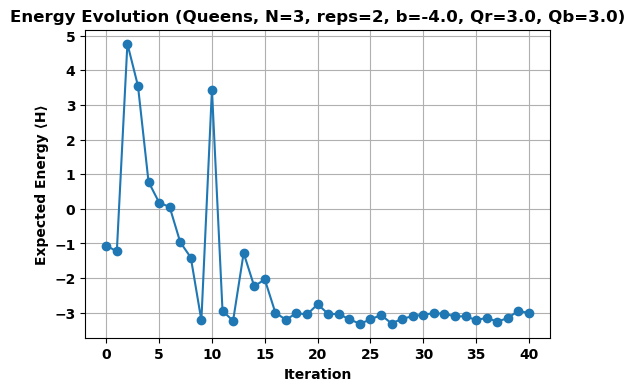

Iter 1 -> Energy = -0.154297
Iter 2 -> Energy = 0.381348
Iter 3 -> Energy = -0.142822
Iter 4 -> Energy = -4.895996
Iter 5 -> Energy = -0.339355
Iter 6 -> Energy = -4.348877
Iter 7 -> Energy = 3.130859
Iter 8 -> Energy = -5.302490
Iter 9 -> Energy = -2.054199
Iter 10 -> Energy = -5.543945
Iter 11 -> Energy = -5.137695
Iter 12 -> Energy = -4.130371
Iter 13 -> Energy = -5.799072
Iter 14 -> Energy = -6.671387
Iter 15 -> Energy = -6.568604
Iter 16 -> Energy = -2.822021
Iter 17 -> Energy = -6.196777
Iter 18 -> Energy = -6.397217
Iter 19 -> Energy = -7.170654
Iter 20 -> Energy = -6.731689
Iter 21 -> Energy = -6.793945
Iter 22 -> Energy = -6.934814
Iter 23 -> Energy = -7.116699
Iter 24 -> Energy = -7.104492
Iter 25 -> Energy = -7.096680
Iter 26 -> Energy = -7.289551
Iter 27 -> Energy = -7.091553
Iter 28 -> Energy = -7.052979
Iter 29 -> Energy = -7.180420
Iter 30 -> Energy = -6.967773
Iter 31 -> Energy = -7.120850
Iter 32 -> Energy = -7.082764
Iter 33 -> Energy = -7.156006
Iter 34 -> Energy = -

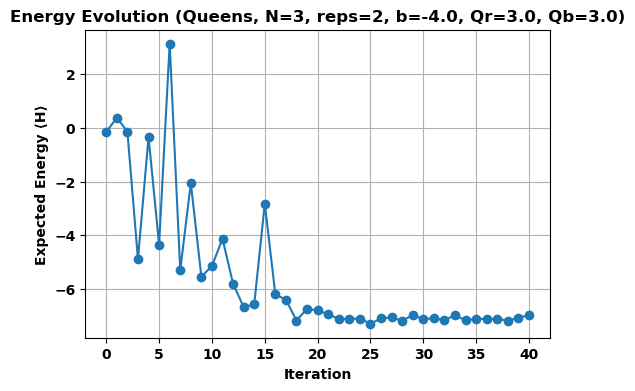

Iter 1 -> Energy = 6.757324
Iter 2 -> Energy = -2.262207
Iter 3 -> Energy = 0.711670
Iter 4 -> Energy = -0.695557
Iter 5 -> Energy = -2.118896
Iter 6 -> Energy = -2.870605
Iter 7 -> Energy = -3.183105
Iter 8 -> Energy = 0.234375
Iter 9 -> Energy = 0.237061
Iter 10 -> Energy = 3.943604
Iter 11 -> Energy = -3.418945
Iter 12 -> Energy = 12.664551
Iter 13 -> Energy = -3.342285
Iter 14 -> Energy = -3.708008
Iter 15 -> Energy = -3.939453
Iter 16 -> Energy = -2.812256
Iter 17 -> Energy = -4.113770
Iter 18 -> Energy = -3.479248
Iter 19 -> Energy = -4.806396
Iter 20 -> Energy = -5.133301
Iter 21 -> Energy = -3.890137
Iter 22 -> Energy = -4.673584
Iter 23 -> Energy = -5.212402
Iter 24 -> Energy = -5.218994
Iter 25 -> Energy = -5.287354
Iter 26 -> Energy = -5.296143
Iter 27 -> Energy = -5.394043
Iter 28 -> Energy = -5.428223
Iter 29 -> Energy = -5.449707
Iter 30 -> Energy = -5.429932
Iter 31 -> Energy = -5.255127
Iter 32 -> Energy = -5.041016
Iter 33 -> Energy = -5.310059
Iter 34 -> Energy = -5.5

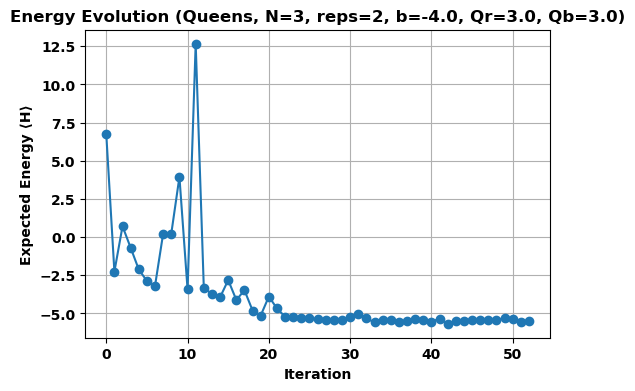

Iter 1 -> Energy = 0.372559
Iter 2 -> Energy = 0.064941
Iter 3 -> Energy = 0.372559
Iter 4 -> Energy = -3.875732
Iter 5 -> Energy = -5.526611
Iter 6 -> Energy = 1.621582
Iter 7 -> Energy = 3.708984
Iter 8 -> Energy = -5.367188
Iter 9 -> Energy = -4.750977
Iter 10 -> Energy = -5.172607
Iter 11 -> Energy = -3.374023
Iter 12 -> Energy = -5.596680
Iter 13 -> Energy = -4.322266
Iter 14 -> Energy = -5.872314
Iter 15 -> Energy = -5.573486
Iter 16 -> Energy = -5.843994
Iter 17 -> Energy = -5.755859
Iter 18 -> Energy = -5.779541
Iter 19 -> Energy = -5.778320
Iter 20 -> Energy = -5.822998
Iter 21 -> Energy = -5.951904
Iter 22 -> Energy = -6.038818
Iter 23 -> Energy = -6.073975
Iter 24 -> Energy = -6.102295
Iter 25 -> Energy = -6.138428
Iter 26 -> Energy = -6.141846
Iter 27 -> Energy = -6.176758
Iter 28 -> Energy = -6.218506
Iter 29 -> Energy = -6.283936
Iter 30 -> Energy = -6.098145
Iter 31 -> Energy = -6.279541
Iter 32 -> Energy = -6.145264
Iter 33 -> Energy = -6.168213
Iter 34 -> Energy = -6.3

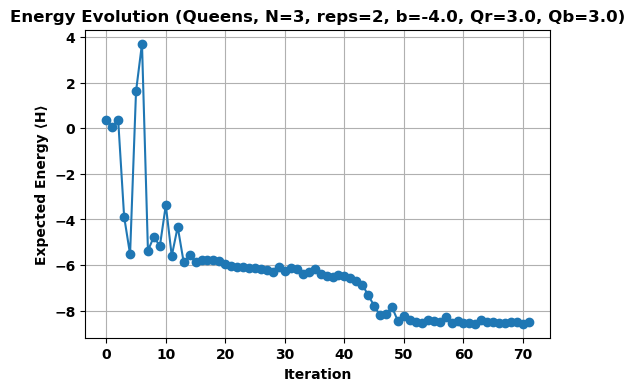

Iter 1 -> Energy = 0.631104
Iter 2 -> Energy = 0.940918
Iter 3 -> Energy = -3.519775
Iter 4 -> Energy = 1.170410
Iter 5 -> Energy = -4.781738
Iter 6 -> Energy = -0.092529
Iter 7 -> Energy = 13.746826
Iter 8 -> Energy = -3.373291
Iter 9 -> Energy = 0.260254
Iter 10 -> Energy = -4.652832
Iter 11 -> Energy = -3.744141
Iter 12 -> Energy = -5.271240
Iter 13 -> Energy = -5.730469
Iter 14 -> Energy = -3.895752
Iter 15 -> Energy = -5.408936
Iter 16 -> Energy = -5.772705
Iter 17 -> Energy = -5.981689
Iter 18 -> Energy = -6.267822
Iter 19 -> Energy = -6.688232
Iter 20 -> Energy = -6.658936
Iter 21 -> Energy = -6.428467
Iter 22 -> Energy = -6.467041
Iter 23 -> Energy = -6.824219
Iter 24 -> Energy = -7.045410
Iter 25 -> Energy = -6.559082
Iter 26 -> Energy = -6.892822
Iter 27 -> Energy = -7.100830
Iter 28 -> Energy = -7.102295
Iter 29 -> Energy = -7.068359
Iter 30 -> Energy = -7.148193
Iter 31 -> Energy = -7.048828
Iter 32 -> Energy = -7.106445
Iter 33 -> Energy = -7.176514
Iter 34 -> Energy = -7.

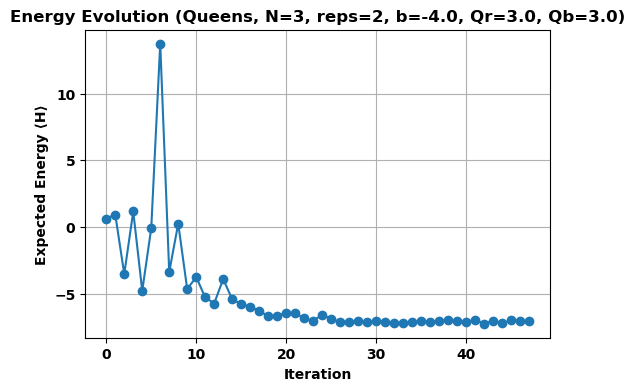

Iter 1 -> Energy = -0.103271
Iter 2 -> Energy = -1.345947
Iter 3 -> Energy = 5.442139
Iter 4 -> Energy = -0.029541
Iter 5 -> Energy = -0.747314
Iter 6 -> Energy = 1.510498
Iter 7 -> Energy = 4.388428
Iter 8 -> Energy = -2.517090
Iter 9 -> Energy = -3.454102
Iter 10 -> Energy = -0.231201
Iter 11 -> Energy = -1.555420
Iter 12 -> Energy = -5.505615
Iter 13 -> Energy = -5.096924
Iter 14 -> Energy = -5.519287
Iter 15 -> Energy = -4.013428
Iter 16 -> Energy = -5.212646
Iter 17 -> Energy = -5.823242
Iter 18 -> Energy = -5.626709
Iter 19 -> Energy = -4.589111
Iter 20 -> Energy = -5.465088
Iter 21 -> Energy = -6.103271
Iter 22 -> Energy = -6.186523
Iter 23 -> Energy = -5.689697
Iter 24 -> Energy = -5.934326
Iter 25 -> Energy = -6.119385
Iter 26 -> Energy = -6.227295
Iter 27 -> Energy = -6.097168
Iter 28 -> Energy = -5.911621
Iter 29 -> Energy = -5.929688
Iter 30 -> Energy = -5.989746
Iter 31 -> Energy = -6.074463
Iter 32 -> Energy = -6.000488
Iter 33 -> Energy = -6.048584
Iter 34 -> Energy = -5

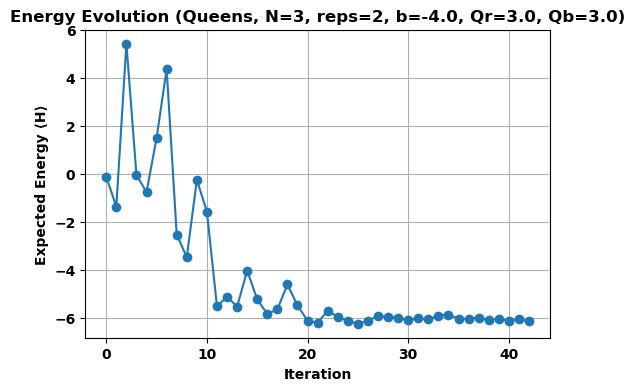

Iter 1 -> Energy = 3.689453
Iter 2 -> Energy = -0.631836
Iter 3 -> Energy = 0.040771
Iter 4 -> Energy = -5.143311
Iter 5 -> Energy = -4.322021
Iter 6 -> Energy = 0.205566
Iter 7 -> Energy = 4.022217
Iter 8 -> Energy = -4.416504
Iter 9 -> Energy = -6.335449
Iter 10 -> Energy = -0.830078
Iter 11 -> Energy = -6.368164
Iter 12 -> Energy = -6.510254
Iter 13 -> Energy = -6.241699
Iter 14 -> Energy = -7.110107
Iter 15 -> Energy = -7.109375
Iter 16 -> Energy = -6.179688
Iter 17 -> Energy = -7.013428
Iter 18 -> Energy = -7.115723
Iter 19 -> Energy = -7.323730
Iter 20 -> Energy = -7.539062
Iter 21 -> Energy = -7.452881
Iter 22 -> Energy = -7.479736
Iter 23 -> Energy = -7.451904
Iter 24 -> Energy = -7.376465
Iter 25 -> Energy = -7.354980
Iter 26 -> Energy = -7.485352
Iter 27 -> Energy = -7.447266
Iter 28 -> Energy = -7.513916
Iter 29 -> Energy = -7.389648
Iter 30 -> Energy = -7.546631
Iter 31 -> Energy = -7.492920
Iter 32 -> Energy = -7.490723
Iter 33 -> Energy = -7.426270
Iter 34 -> Energy = -7.

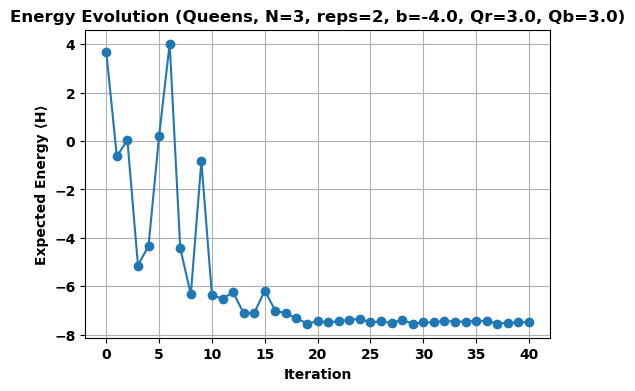

Iter 1 -> Energy = 4.080078
Iter 2 -> Energy = -1.216309
Iter 3 -> Energy = 2.333252
Iter 4 -> Energy = -1.422363
Iter 5 -> Energy = -1.789551
Iter 6 -> Energy = 1.110596
Iter 7 -> Energy = 0.835449
Iter 8 -> Energy = -2.253906
Iter 9 -> Energy = 0.440186
Iter 10 -> Energy = -2.864502
Iter 11 -> Energy = -2.164307
Iter 12 -> Energy = -2.103516
Iter 13 -> Energy = -2.471191
Iter 14 -> Energy = -2.468750
Iter 15 -> Energy = -2.642090
Iter 16 -> Energy = -2.832275
Iter 17 -> Energy = -2.781982
Iter 18 -> Energy = -2.613037
Iter 19 -> Energy = -2.620605
Iter 20 -> Energy = -2.922607
Iter 21 -> Energy = -2.768066
Iter 22 -> Energy = -2.673096
Iter 23 -> Energy = -2.760254
Iter 24 -> Energy = -2.660156
Iter 25 -> Energy = -2.910400
Iter 26 -> Energy = -2.747559
Iter 27 -> Energy = -2.882568
Iter 28 -> Energy = -2.910645
Iter 29 -> Energy = -3.085693
Iter 30 -> Energy = -2.608643
Iter 31 -> Energy = -2.901611
Iter 32 -> Energy = -2.748291
Iter 33 -> Energy = -2.861084
Iter 34 -> Energy = -2.8

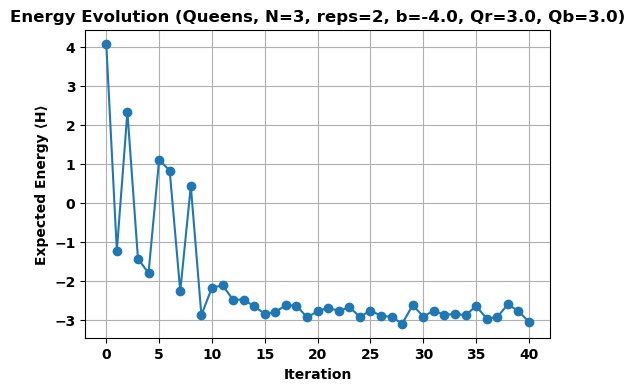


Optimal energy (QAOA): -8.677734375
Optimal params: [0.37107684 6.22447435 6.12715193 0.78844176]


In [360]:
# Run QAOA (change parameters here)
N = 3
reps = 2
b = -4.0
Q_rook = 3.0
Q_bishop = 3.0

# Loop to get the best result over several runs
best_result = None
best_energy = np.inf
num_runs = 10

for run in range(num_runs):
    solutions_q = QAOA_queens(N, b, Q_rook, Q_bishop, build_queen_hamiltonian, cost_function_estimator, reps=reps)

    energy_q = solutions_q["optimal_value"]

    if energy_q < best_energy:
        best_energy = energy_q
        best_result = solutions_q

solutions_q = best_result

print("\nOptimal energy (QAOA):", solutions_q["optimal_value"])
print("Optimal params:", solutions_q["optimal_params"])

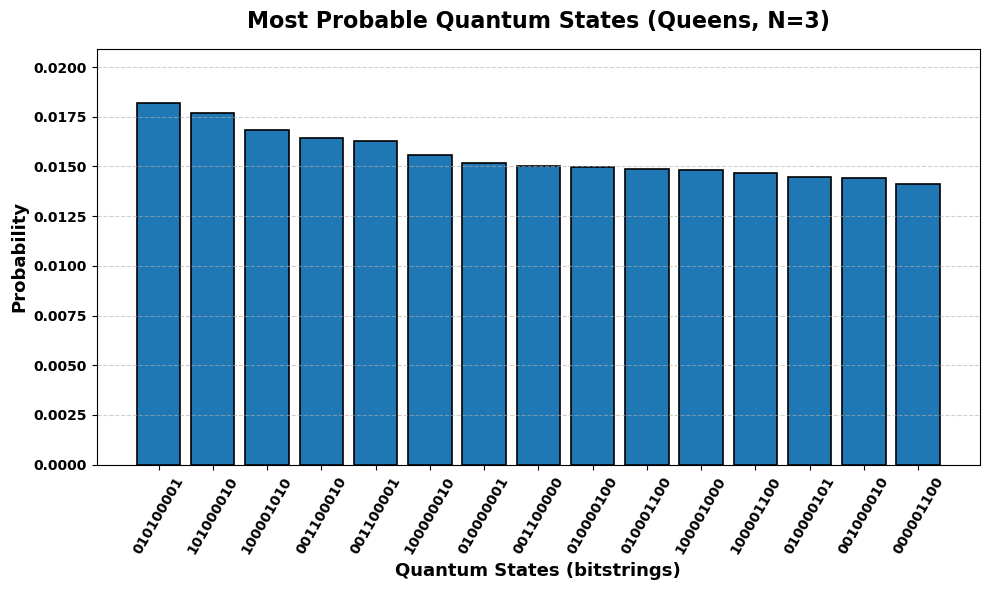

In [361]:
# Measurement and results
backend = AerSimulator()
final = solutions_q["ansatz"].copy()
final.measure_all()
shots = 4096 * 4
job = backend.run(transpile(final, backend), shots=shots)
counts = job.result().get_counts()

# top states and histogram
top_k = 15
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
states, counts_ = zip(*sorted_counts)
probs = np.array(counts_) / shots

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(states, probs, edgecolor='black', linewidth=1.2)
ax.set_title(f"Most Probable Quantum States (Queens, N={N})", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Quantum States (bitstrings)", fontsize=13)
ax.set_ylabel("Probability", fontsize=13)
ax.tick_params(axis='x', rotation=60)
ax.set_ylim(0, max(probs)*1.15)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

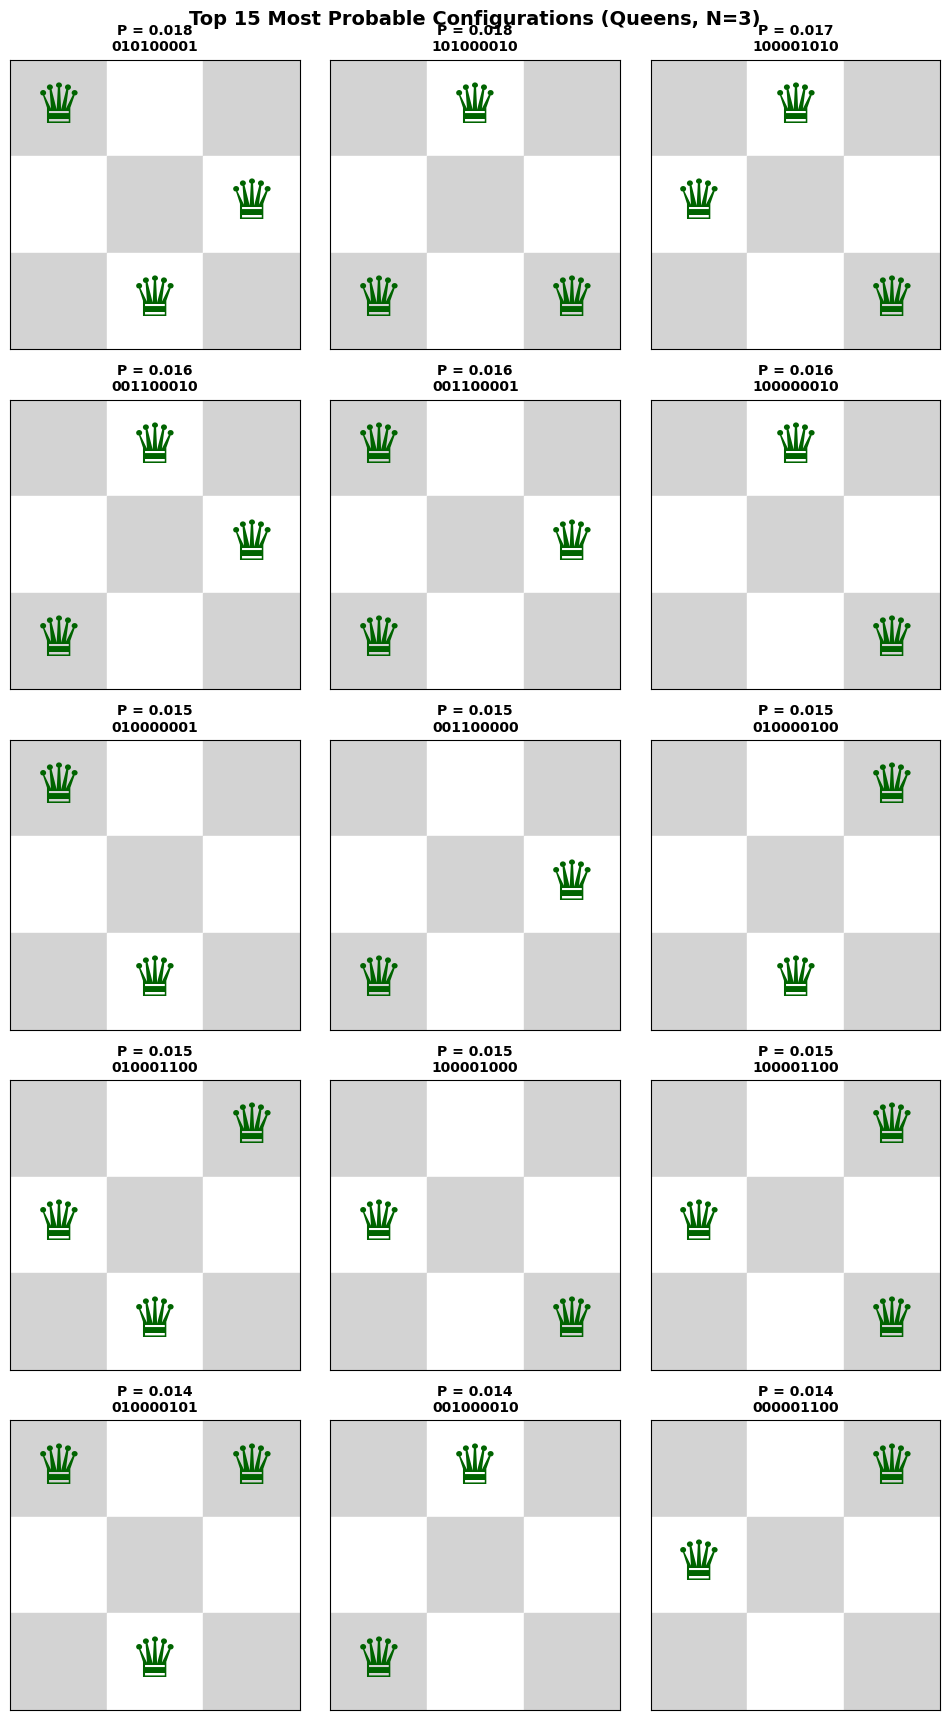

In [362]:
# VISUALIZATION OF TOP QUEEN CONFIGURATIONS

def plot_queens_configuration(bitstring, N, ax):
    """Draws an NxN chessboard with queens (♛) where bits=1."""
    board = np.zeros((N, N))
    bits = bitstring[::-1]  # reverse for intuitive visual order
    for i, bit in enumerate(bits):
        if bit == "1":
            r, c = divmod(i, N)
            board[r, c] = 1

    # Draw board pattern
    for r in range(N):
        for c in range(N):
            color = "lightgray" if (r + c) % 2 == 0 else "white"
            ax.add_patch(plt.Rectangle((c - 0.5, N - 1 - r - 0.5), 1, 1, color=color))

    # Draw queens
    for r in range(N):
        for c in range(N):
            if board[r, c] == 1:
                ax.text(c, N - 1 - r, "♛", ha="center", va="center",
                        fontsize=40, color="darkgreen")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, N - 0.5)
    ax.set_aspect("equal")


# Display grid of top configurations
rows = int(np.ceil(top_k / 3))
cols = min(3, top_k)
fig, axes = plt.subplots(rows, cols, figsize=(10, 3.5 * rows))
axes = np.array(axes).reshape(-1)

for i, (bitstring, count) in enumerate(sorted_counts):
    prob = count / shots
    plot_queens_configuration(bitstring, N, axes[i])
    axes[i].set_title(f"P = {prob:.3f}\n{bitstring}", fontsize=10)

for j in range(len(sorted_counts), len(axes)):
    axes[j].axis("off")

fig.subplots_adjust(hspace=0.4)
fig.suptitle(f"Top {top_k} Most Probable Configurations (Queens, N={N})", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


> Note: The 3x3 board solution only has 2 queens, while the 4x4 one has 4 queens.

# 4- Going to utility-scale problems

Now that you have solved small instances of the queens puzzle you might think, what's next?? Prepare for the most difficult and exciting part of the challenge!!

The previous sections where only restricted to 3x3 and 4x4 boards because bigger circuits are much expensive to simulate using classical computers and will take a lot of time to do the optimization. Then, you might think, Is this worthy?
Yes, it is. If we run it on a quantum computer!!
Try to run 5x5 and 6x6 boards on it!.

Go again to [IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) and try to run a bigger board instance in real quantum hardware.
For that you will need to register on ibm and you will have a maximum of 10 minutes of Q-computations, so be cautious. Plan everything before running it and save every result obtained to present it in the final report.

In [ ]:
# Your code here

# 5- A farm of horses

The queens and rooks and bishops move in lines, but what about horses?

Explore the possible configurations solutions for the horses puzzle for small boards. Is this problem as easy to converge than the other instances? Which is the biggest difference?

In [368]:
# Brute force
import itertools
import numpy as np

def knights_conflict(pos1, pos2):
    (r1, c1), (r2, c2) = pos1, pos2
    return ((abs(r1 - r2) == 2 and abs(c1 - c2) == 1) or
            (abs(r1 - r2) == 1 and abs(c1 - c2) == 2))

def valid_knight_config(positions):
    for (p1, p2) in itertools.combinations(positions, 2):
        if knights_conflict(p1, p2):
            return False
    return True

def brute_force_max_knights(N):
    cells = [(i, j) for i in range(N) for j in range(N)]
    best_solutions = []
    max_knights = 0

    for num_knights in range(1, N * N + 1):
        current_solutions = []
        for combo in itertools.combinations(cells, num_knights):
            if valid_knight_config(combo):
                current_solutions.append(combo)

        if current_solutions:
            max_knights = num_knights
            best_solutions = current_solutions
            print(f"{len(current_solutions)} valid configurations with {num_knights} knights")
        else:
            print("No more valid configurations found.")
            break

    print(f"\nMaximum number of knights: {max_knights}")
    print(f"Number of valid configurations: {len(best_solutions)}")

    return max_knights, best_solutions

def print_board(N, positions):
    board = np.zeros((N, N), dtype=int)
    for (r, c) in positions:
        board[r, c] = 1
    print(board, "\n")


N = 3
max_knights, best_solutions = brute_force_max_knights(N)

print(f"\nMaximum number of knights for {N}x{N}: {max_knights}")
print(f"Showing all {len(best_solutions)} valid configurations:\n")

for idx, sol in enumerate(best_solutions, 1):
    print(f"Configuration {idx}:")
    print_board(N, sol)


9 valid configurations with 1 knights
28 valid configurations with 2 knights
36 valid configurations with 3 knights
18 valid configurations with 4 knights
2 valid configurations with 5 knights
No more valid configurations found.

Maximum number of knights: 5
Number of valid configurations: 2

Maximum number of knights for 3x3: 5
Showing all 2 valid configurations:

Configuration 1:
[[1 0 1]
 [0 1 0]
 [1 0 1]] 

Configuration 2:
[[0 1 0]
 [1 1 1]
 [0 1 0]] 



In [ ]:
# Classical coefficients

def classical_onebody_coeff(N: int, b: float) -> np.ndarray:
    """Uniform one-body term b_{k,a} = b."""
    return np.full((N, N), b)


def classical_knight_twobody_coeff(N: int, Q_knight: float) -> np.ndarray:
    """Two-body coefficients penalizing knights attacking each other."""
    Q = np.zeros((N, N, N, N))
    half = Q_knight / 2.0
    knight_moves = [
        (2, 1), (1, 2), (-1, 2), (-2, 1),
        (-2, -1), (-1, -2), (1, -2), (2, -1)
    ]
    for k in range(N):
        for a in range(N):
            for (dk, da) in knight_moves:
                l = k + dk
                b_ = a + da
                if 0 <= l < N and 0 <= b_ < N:
                    Q[k, a, l, b_] = half
    return Q


def classical_hamiltonian_knights(N: int, b: float, Q_knight: float, X_matrix: np.ndarray) -> float:
    """Classical Hamiltonian value for a given configuration."""
    b_mat = classical_onebody_coeff(N, b)
    Q_mat = classical_knight_twobody_coeff(N, Q_knight)
    e1 = np.sum(b_mat * X_matrix)
    e2 = 0.0
    for k in range(N):
        for a in range(N):
            if X_matrix[k, a] == 1:
                for l in range(N):
                    for b_ in range(N):
                        if X_matrix[l, b_] == 1:
                            e2 += Q_mat[k, a, l, b_]
    return e1 + e2


# Quantum coefficients

def quantum_Z_coeff_knights(N: int, b: float, Q_knight: float) -> np.ndarray:
    """Z-term coefficients (one-body terms)."""
    b_mat = classical_onebody_coeff(N, b)
    Q_mat = classical_knight_twobody_coeff(N, Q_knight)
    cZ = np.zeros((N, N))
    for k in range(N):
        for a in range(N):
            b_term = -b_mat[k, a] / 2.0
            Q_term = -0.5 * np.sum(Q_mat[k, a, :, :])
            cZ[k, a] = b_term + Q_term
    return cZ


def quantum_ZZ_coeff_knights(N: int, Q_knight: float) -> np.ndarray:
    """ZZ-term coefficients (two-body terms)."""
    Q_mat = classical_knight_twobody_coeff(N, Q_knight)
    return Q_mat / 4.0


# Build SparsePauliOp Hamiltonian

def build_knight_hamiltonian(N: int, b: float, Q_knight: float) -> SparsePauliOp:
    num_qubits = N * N
    cZ = quantum_Z_coeff_knights(N, b, Q_knight)
    cZZ = quantum_ZZ_coeff_knights(N, Q_knight)

    pauli_list = []
    coeff_list = []

    # Z terms
    for k in range(N):
        for a in range(N):
            coeff = cZ[k, a]
            if coeff != 0:
                qubit_index = k * N + a
                string_index = num_qubits - 1 - qubit_index
                z_op = ['I'] * num_qubits
                z_op[string_index] = 'Z'
                pauli_list.append("".join(z_op))
                coeff_list.append(coeff)

    # ZZ terms
    for k in range(N):
        for a in range(N):
            i = k * N + a
            for l in range(N):
                for b_ in range(N):
                    j = l * N + b_
                    if i < j:
                        coeff = cZZ[k, a, l, b_] + cZZ[l, b_, k, a]
                        if coeff != 0:
                            s = ['I'] * num_qubits
                            s[num_qubits - 1 - i] = 'Z'
                            s[num_qubits - 1 - j] = 'Z'
                            pauli_list.append("".join(s))
                            coeff_list.append(coeff)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)


In [ ]:
# QAOA routine (knights)

def cost_function_estimator(circuit, hamiltonian):
    estimator = Estimator(mode=AerSimulator())
    job = estimator.run([(circuit, hamiltonian)])
    result = job.result()
    return float(result[0].data.evs)


def QAOA_knights(N, b, Q_knight, cost_hamiltonian, cost_function, reps=2):
    H = cost_hamiltonian(N, b, Q_knight)
    ansatz = QAOAAnsatz(cost_operator=H, reps=reps)
    backend = AerSimulator()
    energy_log = []

    def objective(params):
        bound = ansatz.assign_parameters(params)
        transp = transpile(bound, backend)
        val = cost_function(transp, H)
        energy_log.append(val)
        print(f"Iter {len(energy_log)} -> Energy = {val:.6f}")
        return val

    init = np.random.uniform(0, 2 * np.pi, len(ansatz.parameters))
    res = minimize(objective, init, method="COBYLA", options={"maxiter": 150, "disp": False})
    final_circuit = ansatz.assign_parameters(res.x)

    plt.figure(figsize=(6, 4))
    plt.plot(energy_log, marker='o')
    plt.xlabel("Iteration"); plt.ylabel("Expected Energy ⟨H⟩")
    plt.title(f"Energy Evolution (Knights, N={N}, reps={reps}, b={b}, Qk={Q_knight})")
    plt.grid(True); plt.show()

    return {"optimal_value": res.fun, "optimal_params": res.x, "ansatz": final_circuit,
            "energy_log": energy_log, "H": H}



Iter 1 -> Energy = 0.968018
Iter 2 -> Energy = 0.592529
Iter 3 -> Energy = 1.296143
Iter 4 -> Energy = -1.572754
Iter 5 -> Energy = 0.499023
Iter 6 -> Energy = 0.554199
Iter 7 -> Energy = -0.895264
Iter 8 -> Energy = -1.654053
Iter 9 -> Energy = -1.435059
Iter 10 -> Energy = -1.857422
Iter 11 -> Energy = -2.121094
Iter 12 -> Energy = -2.291992
Iter 13 -> Energy = -2.152588
Iter 14 -> Energy = -2.125000
Iter 15 -> Energy = -2.347656
Iter 16 -> Energy = -2.184814
Iter 17 -> Energy = -2.358398
Iter 18 -> Energy = -2.350098
Iter 19 -> Energy = -2.355225
Iter 20 -> Energy = -2.311279
Iter 21 -> Energy = -2.339355
Iter 22 -> Energy = -2.332275
Iter 23 -> Energy = -2.289551
Iter 24 -> Energy = -2.282959
Iter 25 -> Energy = -2.264404
Iter 26 -> Energy = -2.316406
Iter 27 -> Energy = -2.310791
Iter 28 -> Energy = -2.287109
Iter 29 -> Energy = -2.350342
Iter 30 -> Energy = -2.330322
Iter 31 -> Energy = -2.278320
Iter 32 -> Energy = -2.318115
Iter 33 -> Energy = -2.300049
Iter 34 -> Energy = -2.3

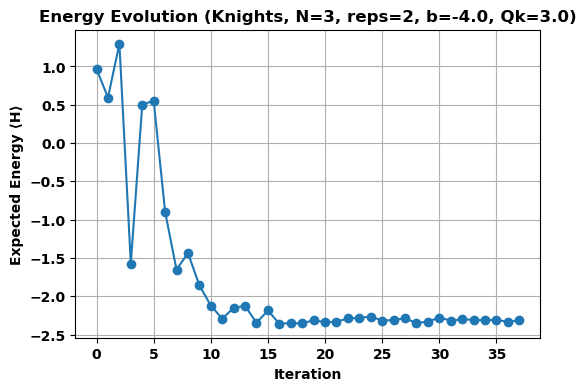

Iter 1 -> Energy = 3.335205
Iter 2 -> Energy = 0.181885
Iter 3 -> Energy = 0.185059
Iter 4 -> Energy = 2.389893
Iter 5 -> Energy = -1.114746
Iter 6 -> Energy = 1.244873
Iter 7 -> Energy = -3.165283
Iter 8 -> Energy = 1.688721
Iter 9 -> Energy = -0.173096
Iter 10 -> Energy = -2.202637
Iter 11 -> Energy = -1.880127
Iter 12 -> Energy = -3.152344
Iter 13 -> Energy = -3.642578
Iter 14 -> Energy = -3.807373
Iter 15 -> Energy = -3.256104
Iter 16 -> Energy = -4.141357
Iter 17 -> Energy = -4.255859
Iter 18 -> Energy = -3.703613
Iter 19 -> Energy = -4.512695
Iter 20 -> Energy = -4.427979
Iter 21 -> Energy = -4.292480
Iter 22 -> Energy = -4.706299
Iter 23 -> Energy = -4.449219
Iter 24 -> Energy = -4.318115
Iter 25 -> Energy = -4.715088
Iter 26 -> Energy = -4.682861
Iter 27 -> Energy = -4.694092
Iter 28 -> Energy = -4.679932
Iter 29 -> Energy = -4.704590
Iter 30 -> Energy = -4.746582
Iter 31 -> Energy = -4.715576
Iter 32 -> Energy = -4.685547
Iter 33 -> Energy = -4.696045
Iter 34 -> Energy = -4.72

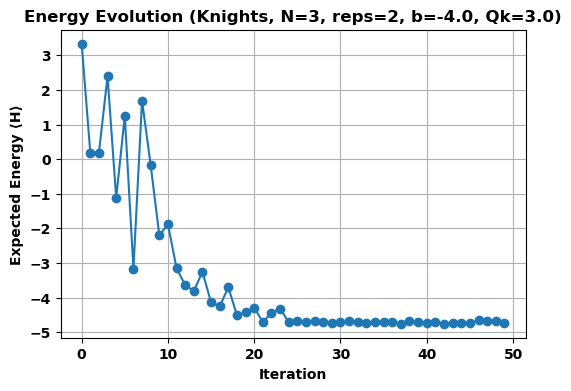

Iter 1 -> Energy = -2.897461
Iter 2 -> Energy = 1.943359
Iter 3 -> Energy = 6.073242
Iter 4 -> Energy = 5.010986
Iter 5 -> Energy = -2.017822
Iter 6 -> Energy = 0.011475
Iter 7 -> Energy = 1.098877
Iter 8 -> Energy = -3.428467
Iter 9 -> Energy = -2.127930
Iter 10 -> Energy = -3.224121
Iter 11 -> Energy = -3.320801
Iter 12 -> Energy = -3.623535
Iter 13 -> Energy = -3.789062
Iter 14 -> Energy = -3.710205
Iter 15 -> Energy = -4.126221
Iter 16 -> Energy = -3.522949
Iter 17 -> Energy = -4.106445
Iter 18 -> Energy = -3.849609
Iter 19 -> Energy = -4.044922
Iter 20 -> Energy = -4.139404
Iter 21 -> Energy = -4.056152
Iter 22 -> Energy = -4.094482
Iter 23 -> Energy = -4.119385
Iter 24 -> Energy = -4.154541
Iter 25 -> Energy = -4.131592
Iter 26 -> Energy = -4.074219
Iter 27 -> Energy = -4.132324
Iter 28 -> Energy = -4.143555
Iter 29 -> Energy = -4.028076
Iter 30 -> Energy = -4.099609
Iter 31 -> Energy = -4.133789
Iter 32 -> Energy = -4.092285
Iter 33 -> Energy = -4.055420
Iter 34 -> Energy = -4.1

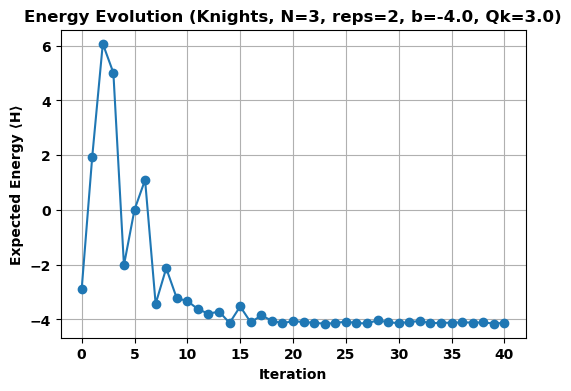

Iter 1 -> Energy = -0.387207
Iter 2 -> Energy = 0.099121
Iter 3 -> Energy = 0.247070
Iter 4 -> Energy = -0.280273
Iter 5 -> Energy = -0.055664
Iter 6 -> Energy = 1.597412
Iter 7 -> Energy = 1.167480
Iter 8 -> Energy = -1.085938
Iter 9 -> Energy = 0.023438
Iter 10 -> Energy = -0.106934
Iter 11 -> Energy = -0.698486
Iter 12 -> Energy = -0.972412
Iter 13 -> Energy = -2.462891
Iter 14 -> Energy = -2.584717
Iter 15 -> Energy = -2.871582
Iter 16 -> Energy = -2.760498
Iter 17 -> Energy = -2.435303
Iter 18 -> Energy = -3.338867
Iter 19 -> Energy = -3.045166
Iter 20 -> Energy = -2.921143
Iter 21 -> Energy = -3.240967
Iter 22 -> Energy = -3.608154
Iter 23 -> Energy = -3.875977
Iter 24 -> Energy = -3.845947
Iter 25 -> Energy = -3.867432
Iter 26 -> Energy = -3.912598
Iter 27 -> Energy = -3.893066
Iter 28 -> Energy = -3.822998
Iter 29 -> Energy = -3.830322
Iter 30 -> Energy = -3.830078
Iter 31 -> Energy = -3.854736
Iter 32 -> Energy = -3.971680
Iter 33 -> Energy = -3.904053
Iter 34 -> Energy = -3.9

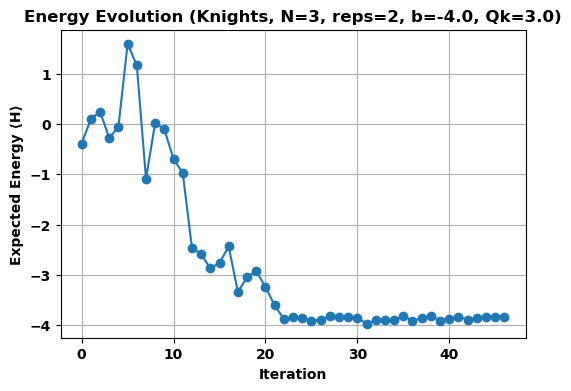

Iter 1 -> Energy = 4.809814
Iter 2 -> Energy = 2.382812
Iter 3 -> Energy = -2.734863
Iter 4 -> Energy = -0.778076
Iter 5 -> Energy = 1.483643
Iter 6 -> Energy = 1.359131
Iter 7 -> Energy = -1.216553
Iter 8 -> Energy = -1.436768
Iter 9 -> Energy = -2.963623
Iter 10 -> Energy = -3.185547
Iter 11 -> Energy = -3.434814
Iter 12 -> Energy = -3.409180
Iter 13 -> Energy = -3.298828
Iter 14 -> Energy = -3.518066
Iter 15 -> Energy = -3.293457
Iter 16 -> Energy = -3.549072
Iter 17 -> Energy = -3.270020
Iter 18 -> Energy = -3.484863
Iter 19 -> Energy = -3.490479
Iter 20 -> Energy = -3.572998
Iter 21 -> Energy = -3.538574
Iter 22 -> Energy = -3.532227
Iter 23 -> Energy = -3.532715
Iter 24 -> Energy = -3.546875
Iter 25 -> Energy = -3.506592
Iter 26 -> Energy = -3.583984
Iter 27 -> Energy = -3.575928
Iter 28 -> Energy = -3.477783
Iter 29 -> Energy = -3.491211
Iter 30 -> Energy = -3.522217
Iter 31 -> Energy = -3.517822
Iter 32 -> Energy = -3.505859
Iter 33 -> Energy = -3.496094
Iter 34 -> Energy = -3.

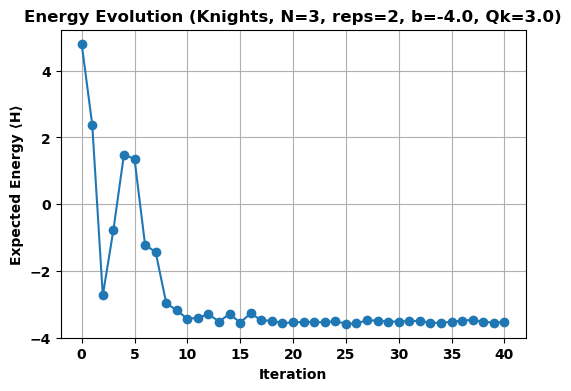

Iter 1 -> Energy = 5.135498
Iter 2 -> Energy = -0.363770
Iter 3 -> Energy = 7.880371
Iter 4 -> Energy = 1.818848
Iter 5 -> Energy = -1.833496
Iter 6 -> Energy = -0.940430
Iter 7 -> Energy = -1.343018
Iter 8 -> Energy = -1.584961
Iter 9 -> Energy = -2.140869
Iter 10 -> Energy = -1.256836
Iter 11 -> Energy = -1.995117
Iter 12 -> Energy = -1.974121
Iter 13 -> Energy = -1.997803
Iter 14 -> Energy = -2.120605
Iter 15 -> Energy = -1.901123
Iter 16 -> Energy = -2.158203
Iter 17 -> Energy = -2.057373
Iter 18 -> Energy = -2.045166
Iter 19 -> Energy = -2.197998
Iter 20 -> Energy = -2.077148
Iter 21 -> Energy = -2.164551
Iter 22 -> Energy = -2.163086
Iter 23 -> Energy = -2.045166
Iter 24 -> Energy = -2.116455
Iter 25 -> Energy = -2.046875
Iter 26 -> Energy = -2.126465
Iter 27 -> Energy = -2.085693
Iter 28 -> Energy = -2.126953
Iter 29 -> Energy = -2.117676
Iter 30 -> Energy = -2.152344
Iter 31 -> Energy = -2.093262
Iter 32 -> Energy = -2.138916
Iter 33 -> Energy = -2.161133
Iter 34 -> Energy = -2

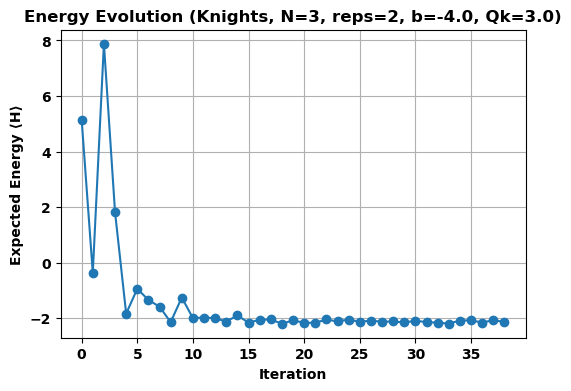

Iter 1 -> Energy = 0.268799
Iter 2 -> Energy = 1.796631
Iter 3 -> Energy = 2.526123
Iter 4 -> Energy = 0.619385
Iter 5 -> Energy = -1.229736
Iter 6 -> Energy = 0.800537
Iter 7 -> Energy = 3.345459
Iter 8 -> Energy = -3.051025
Iter 9 -> Energy = -1.623535
Iter 10 -> Energy = -2.877197
Iter 11 -> Energy = -3.785645
Iter 12 -> Energy = -4.172852
Iter 13 -> Energy = -3.778564
Iter 14 -> Energy = -4.202637
Iter 15 -> Energy = -3.888672
Iter 16 -> Energy = -4.566406
Iter 17 -> Energy = -4.275635
Iter 18 -> Energy = -4.388184
Iter 19 -> Energy = -4.638916
Iter 20 -> Energy = -4.489258
Iter 21 -> Energy = -3.823486
Iter 22 -> Energy = -4.400635
Iter 23 -> Energy = -4.553955
Iter 24 -> Energy = -4.644287
Iter 25 -> Energy = -4.610352
Iter 26 -> Energy = -4.682861
Iter 27 -> Energy = -4.674561
Iter 28 -> Energy = -4.534668
Iter 29 -> Energy = -4.640869
Iter 30 -> Energy = -4.579346
Iter 31 -> Energy = -4.532959
Iter 32 -> Energy = -4.603271
Iter 33 -> Energy = -4.604248
Iter 34 -> Energy = -4.59

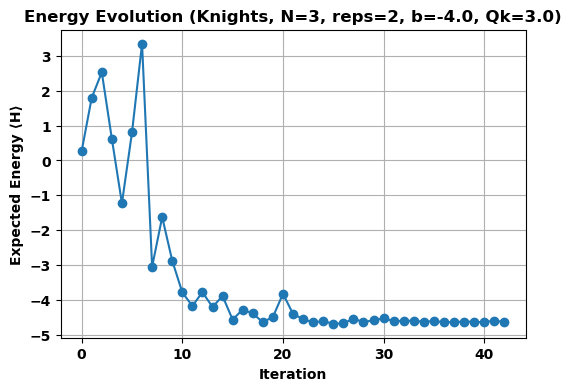

Iter 1 -> Energy = 1.494385
Iter 2 -> Energy = 0.297607
Iter 3 -> Energy = 0.953857
Iter 4 -> Energy = -0.527832
Iter 5 -> Energy = 1.946777
Iter 6 -> Energy = 1.226318
Iter 7 -> Energy = 1.124268
Iter 8 -> Energy = -2.347168
Iter 9 -> Energy = -4.472900
Iter 10 -> Energy = -2.887695
Iter 11 -> Energy = -4.833984
Iter 12 -> Energy = -4.914551
Iter 13 -> Energy = -4.695557
Iter 14 -> Energy = -5.171387
Iter 15 -> Energy = -5.478271
Iter 16 -> Energy = -4.971680
Iter 17 -> Energy = -5.427002
Iter 18 -> Energy = -5.513916
Iter 19 -> Energy = -5.567139
Iter 20 -> Energy = -5.559570
Iter 21 -> Energy = -5.537354
Iter 22 -> Energy = -5.591309
Iter 23 -> Energy = -5.556641
Iter 24 -> Energy = -5.528809
Iter 25 -> Energy = -5.600098
Iter 26 -> Energy = -5.548584
Iter 27 -> Energy = -5.557617
Iter 28 -> Energy = -5.555664
Iter 29 -> Energy = -5.540527
Iter 30 -> Energy = -5.581787
Iter 31 -> Energy = -5.541504
Iter 32 -> Energy = -5.524414
Iter 33 -> Energy = -5.507324
Iter 34 -> Energy = -5.55

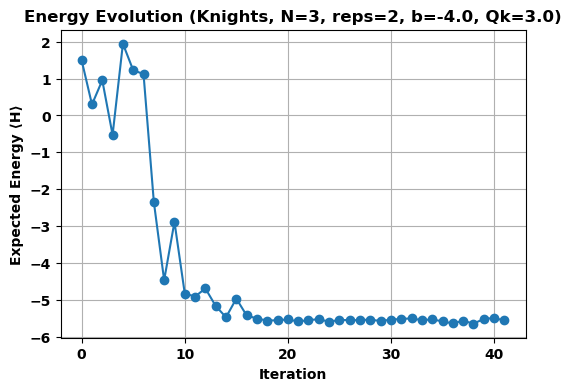

Iter 1 -> Energy = 1.337402
Iter 2 -> Energy = -1.852051
Iter 3 -> Energy = 1.927734
Iter 4 -> Energy = -0.943115
Iter 5 -> Energy = -4.956055
Iter 6 -> Energy = 5.778320
Iter 7 -> Energy = -1.949463
Iter 8 -> Energy = -5.298096
Iter 9 -> Energy = -3.612793
Iter 10 -> Energy = -5.298828
Iter 11 -> Energy = -5.038574
Iter 12 -> Energy = -5.320312
Iter 13 -> Energy = -4.842529
Iter 14 -> Energy = -5.256592
Iter 15 -> Energy = -5.288330
Iter 16 -> Energy = -5.233887
Iter 17 -> Energy = -5.291260
Iter 18 -> Energy = -5.275146
Iter 19 -> Energy = -5.266602
Iter 20 -> Energy = -5.329102
Iter 21 -> Energy = -5.279053
Iter 22 -> Energy = -5.298584
Iter 23 -> Energy = -5.244385
Iter 24 -> Energy = -5.284912
Iter 25 -> Energy = -5.313232
Iter 26 -> Energy = -5.306641
Iter 27 -> Energy = -5.340332
Iter 28 -> Energy = -5.279541
Iter 29 -> Energy = -5.288818
Iter 30 -> Energy = -5.357666
Iter 31 -> Energy = -5.325928
Iter 32 -> Energy = -5.289795
Iter 33 -> Energy = -5.314209
Iter 34 -> Energy = -5

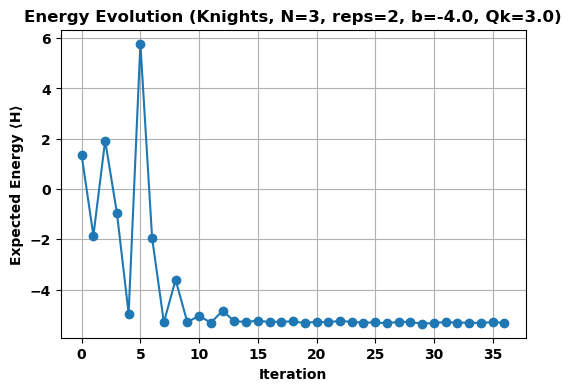

Iter 1 -> Energy = -2.278076
Iter 2 -> Energy = 3.840820
Iter 3 -> Energy = 3.843506
Iter 4 -> Energy = 3.709229
Iter 5 -> Energy = -1.374268
Iter 6 -> Energy = 1.656494
Iter 7 -> Energy = 1.238525
Iter 8 -> Energy = -1.130859
Iter 9 -> Energy = -1.404785
Iter 10 -> Energy = -2.518311
Iter 11 -> Energy = -2.998779
Iter 12 -> Energy = -3.474854
Iter 13 -> Energy = -3.719727
Iter 14 -> Energy = -3.548340
Iter 15 -> Energy = -3.641846
Iter 16 -> Energy = -3.513916
Iter 17 -> Energy = -3.526123
Iter 18 -> Energy = -3.675537
Iter 19 -> Energy = -3.662842
Iter 20 -> Energy = -3.647217
Iter 21 -> Energy = -3.666504
Iter 22 -> Energy = -3.655518
Iter 23 -> Energy = -3.686768
Iter 24 -> Energy = -3.667725
Iter 25 -> Energy = -3.666504
Iter 26 -> Energy = -3.674316
Iter 27 -> Energy = -3.594727
Iter 28 -> Energy = -3.704102
Iter 29 -> Energy = -3.687744
Iter 30 -> Energy = -3.703613
Iter 31 -> Energy = -3.649658
Iter 32 -> Energy = -3.729004
Iter 33 -> Energy = -3.662109
Iter 34 -> Energy = -3.6

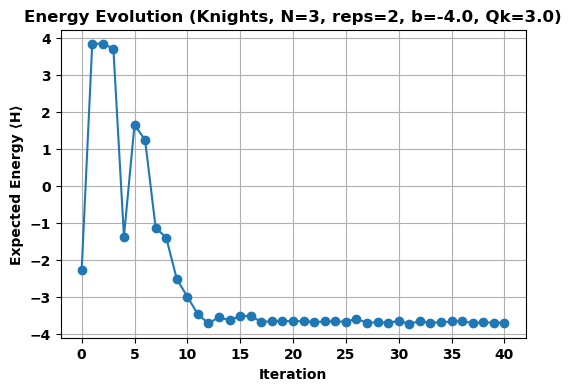


Optimal energy (QAOA): -5.653076171875
Optimal params: [5.66585577 4.15965921 5.69992776 0.25401862]


In [ ]:
# Run QAOA

N = 3
reps = 2
b = -4.0
Q_knight = 3.0

best_result = None
best_energy = np.inf
num_runs = 10

for run in range(num_runs):
    solutions_k = QAOA_knights(N, b, Q_knight, build_knight_hamiltonian, cost_function_estimator, reps=reps)
    energy_k = solutions_k["optimal_value"]
    if energy_k < best_energy:
        best_energy = energy_k
        best_result = solutions_k

solutions_k = best_result

print("\nOptimal energy (QAOA):", solutions_k["optimal_value"])
print("Optimal params:", solutions_k["optimal_params"])

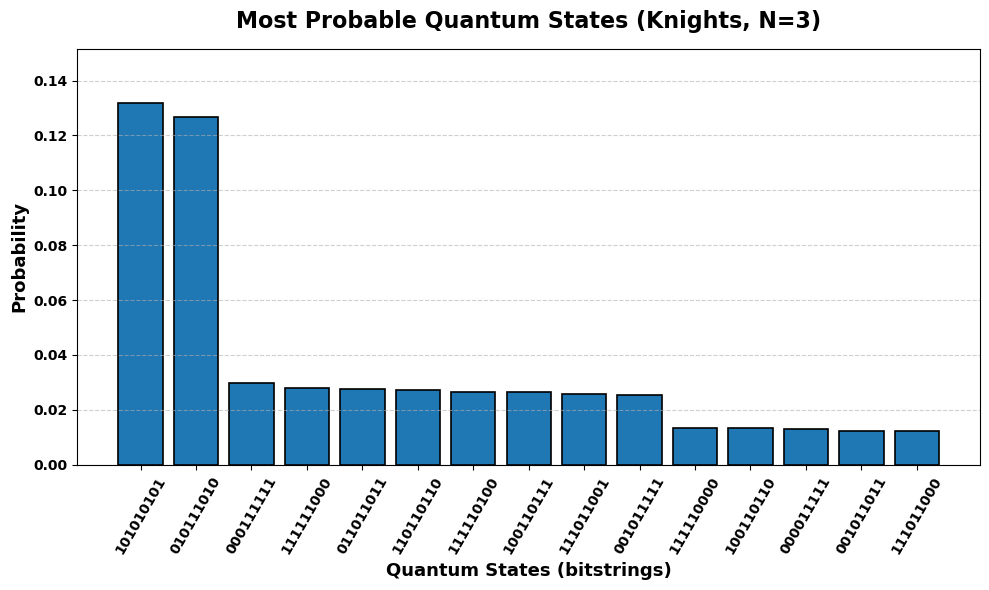

In [366]:
# Measurement and results
# ------------------------------

backend = AerSimulator()
final = solutions_k["ansatz"].copy()
final.measure_all()
shots = 4096 * 4
job = backend.run(transpile(final, backend), shots=shots)
counts = job.result().get_counts()

# Top states and histogram
top_k = 15
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
states, counts_ = zip(*sorted_counts)
probs = np.array(counts_) / shots

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(states, probs, edgecolor='black', linewidth=1.2)
ax.set_title(f"Most Probable Quantum States (Knights, N={N})", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Quantum States (bitstrings)", fontsize=13)
ax.set_ylabel("Probability", fontsize=13)
ax.tick_params(axis='x', rotation=60)
ax.set_ylim(0, max(probs)*1.15)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


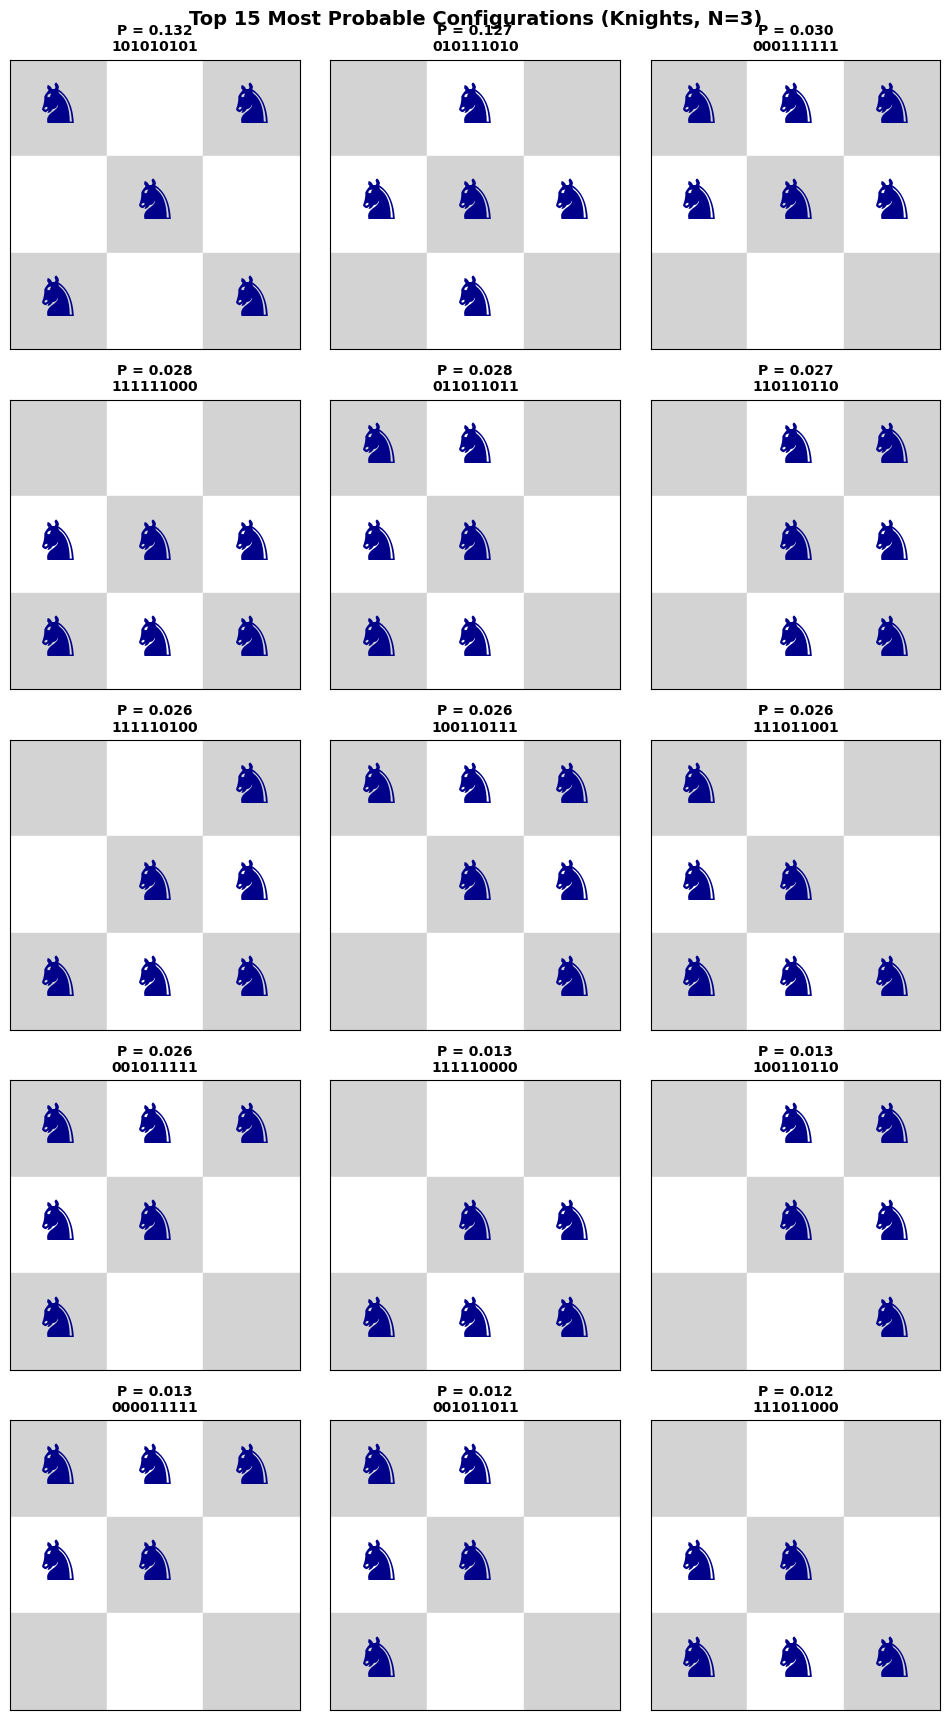

In [367]:
# VISUALIZATION OF TOP KNIGHT CONFIGURATIONS
# ------------------------------

def plot_knights_configuration(bitstring, N, ax):
    """Draws an NxN chessboard with knights (♞) where bits=1."""
    board = np.zeros((N, N))
    bits = bitstring[::-1]  # reverse for visual consistency
    for i, bit in enumerate(bits):
        if bit == "1":
            r, c = divmod(i, N)
            board[r, c] = 1

    # Draw board pattern
    for r in range(N):
        for c in range(N):
            color = "lightgray" if (r + c) % 2 == 0 else "white"
            ax.add_patch(plt.Rectangle((c - 0.5, N - 1 - r - 0.5), 1, 1, color=color))

    # Draw knights
    for r in range(N):
        for c in range(N):
            if board[r, c] == 1:
                ax.text(c, N - 1 - r, "♞", ha="center", va="center",
                        fontsize=40, color="darkblue")

    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(-0.5, N - 0.5); ax.set_ylim(-0.5, N - 0.5)
    ax.set_aspect("equal")


# Display grid of top configurations
rows = int(np.ceil(top_k / 3))
cols = min(3, top_k)
fig, axes = plt.subplots(rows, cols, figsize=(10, 3.5 * rows))
axes = np.array(axes).reshape(-1)

for i, (bitstring, count) in enumerate(sorted_counts):
    prob = count / shots
    plot_knights_configuration(bitstring, N, axes[i])
    axes[i].set_title(f"P = {prob:.3f}\n{bitstring}", fontsize=10)

for j in range(len(sorted_counts), len(axes)):
    axes[j].axis("off")

fig.subplots_adjust(hspace=0.4)
fig.suptitle(f"Top {top_k} Most Probable Configurations (Knights, N={N})",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 6- A parallel story  (Truly challenging - research level)

Read the following works about the queens puzzle and compare what they propose with the things that we have done here:

- https://arxiv.org/html/2312.16312v1
- https://quantum-journal.org/papers/q-2019-06-03-149/

Based on those articles, which changes should be done to improve the resolution of the problem? Do you think that this will make a substantial change on your outcomes?

Can you improve the solution of the problem? Maybe propose a new mapping? Maybe use a different algorithm? 

Open solution question, let your imagination running!

In [ ]:
# Your code here